# 0.Introduction

1. Understand the problem. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
   
2. Univariable study. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it
3. Multivariate study. We'll try to understand how the dependent variable and independent variables relate.
4. Basic cleaning. We'll clean the dataset and handle the missing data, outliers and categorical variable.
5. Test assumptions. We'll check if our data meets the assumptions required by most multivariate techniques.


# 1.Data preparation

I will focus on preparing and cleaning the main voting data. But first let's include useful libraries:

In [2]:
#Basic
import numpy as np
import pandas as pd
import collections

#Plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px

#Regular modeling
import folium
import matplotlib
import statsmodels.api as sm
from itertools import groupby
from operator import itemgetter
from math import sqrt

#Extended modeling
import matplotlib
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn import metrics, mixture, cluster, datasets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,NMF

from mlxtend.preprocessing import minmax_scaling

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
df_governors = pd.read_csv('governors_county_candidate.csv')
df_president = pd.read_csv('president_county_candidate.csv')
df_senate = pd.read_csv('senate_county_candidate.csv')

print("The number of rows for senate: " + format(df_senate.shape[0]) + ". The number of factors: " + format(df_senate.shape[1]))
print("The number of rows for president: " + format(df_president.shape[0]) + ". The number of factors: " + format(df_president.shape[1]))
print("The number of rows for governors: " + format(df_governors.shape[0]) + ". The number of factors: " + format(df_governors.shape[1]))

The number of rows for senate: 14125. The number of factors: 5
The number of rows for president: 32177. The number of factors: 6
The number of rows for governors: 5145. The number of factors: 6


In [143]:
df_governors.head()

state             county        candidate party   votes    won
0  Delaware        Kent County      John Carney   DEM   44352   True
1  Delaware        Kent County  Julianne Murray   REP   39332  False
2  Delaware        Kent County  Kathy DeMatteis   IPD    1115  False
3  Delaware        Kent County    John Machurek   LIB     616  False
4  Delaware  New Castle County      John Carney   DEM  191678   True

In [144]:
df_senate.head()

state             county      candidate party  total_votes
0  Delaware        Kent County  Lauren Witzke   REP        38571
1  Delaware        Kent County    Mark Turley   IPD         1553
2  Delaware        Kent County   Nadine Frost   LIB          958
3  Delaware  New Castle County  Lauren Witzke   REP        80081
4  Delaware  New Castle County    Mark Turley   IPD         4277

In [149]:
df_president.head()

state             county      candidate party  total_votes    won
0  Delaware        Kent County      Joe Biden   DEM        44552   True
1  Delaware        Kent County   Donald Trump   REP        41009  False
2  Delaware        Kent County   Jo Jorgensen   LIB         1044  False
3  Delaware        Kent County  Howie Hawkins   GRN          420  False
4  Delaware  New Castle County      Joe Biden   DEM       195034   True

In [151]:
df = pd.merge(df_president, df_senate, on=['state', 'county'],how='left')
df = pd.merge(df, df_governors, on=['state', 'county'],how='left')

In [153]:
df.head()

state       county candidate_x party_x  total_votes_x  won_x  \
0  Delaware  Kent County   Joe Biden     DEM          44552   True   
1  Delaware  Kent County   Joe Biden     DEM          44552   True   
2  Delaware  Kent County   Joe Biden     DEM          44552   True   
3  Delaware  Kent County   Joe Biden     DEM          44552   True   
4  Delaware  Kent County   Joe Biden     DEM          44552   True   

     candidate_y party_y  total_votes_y        candidate party    votes  won_y  
0  Lauren Witzke     REP        38571.0      John Carney   DEM  44352.0   True  
1  Lauren Witzke     REP        38571.0  Julianne Murray   REP  39332.0  False  
2  Lauren Witzke     REP        38571.0  Kathy DeMatteis   IPD   1115.0  False  
3  Lauren Witzke     REP        38571.0    John Machurek   LIB    616.0  False  
4    Mark Turley     IPD         1553.0      John Carney   DEM  44352.0   True


Let's look at presidential one:

In [156]:
df_president.head(5)

state             county      candidate party  total_votes    won
0  Delaware        Kent County      Joe Biden   DEM        44552   True
1  Delaware        Kent County   Donald Trump   REP        41009  False
2  Delaware        Kent County   Jo Jorgensen   LIB         1044  False
3  Delaware        Kent County  Howie Hawkins   GRN          420  False
4  Delaware  New Castle County      Joe Biden   DEM       195034   True

In [158]:
df_president_agg_REP  = df_president[(df_president.party == "REP")]
df_president_agg_DEM  = df_president[(df_president.party == "DEM")]
#df_president_agg_LIB  = df_president[(df_president.party == "LIB")]
df_president_agg_REP = pd.DataFrame(df_president_agg_REP.groupby(['state', 'county'])['total_votes'].sum())
df_president_agg_DEM = pd.DataFrame(df_president_agg_DEM.groupby(['state', 'county'])['total_votes'].sum())
#df_president_agg_LIB = pd.DataFrame(df_president_agg_LIB.groupby(['state', 'county'])['total_votes'].sum())
df_president_agg_REP = df_president_agg_REP.rename(columns={"total_votes": "votes REP president"})
df_president_agg_DEM = df_president_agg_DEM.rename(columns={"total_votes": "votes DEM president"})
#df_president_agg_LIB = df_president_agg_LIB.rename(columns={"total_votes": "votes LIB president"})


df_president_agg = pd.merge(df_president_agg_DEM, df_president_agg_REP, on=['state', 'county'], how='left')

#df_president_agg = pd.merge(df_president_agg, df_president_agg_LIB, on=['state'], how='left')

df_president_agg.head()


votes DEM president  votes REP president
state   county                                                  
Alabama Autauga County                 7503                19838
        Baldwin County                24578                83544
        Barbour County                 4816                 5622
        Bibb County                    1986                 7525
        Blount County                  2640                24711

In [160]:
df_senate_agg_REP  = df_senate[(df_senate.party == "REP")]
df_senate_agg_DEM  = df_senate[(df_senate.party == "DEM")]
df_senate_agg_REP = pd.DataFrame(df_senate_agg_REP.groupby(['state', 'county'])['total_votes'].sum())
df_senate_agg_DEM = pd.DataFrame(df_senate_agg_DEM.groupby(['state', 'county'])['total_votes'].sum())
df_senate_agg_REP = df_senate_agg_REP.rename(columns={"total_votes": "votes REP senate"})
df_senate_agg_DEM = df_senate_agg_DEM.rename(columns={"total_votes": "votes DEM senate"})
df_senate_agg = pd.merge(df_senate_agg_DEM, df_senate_agg_REP, on=['state', 'county'],how='outer')


df_governors_agg_REP  = df_governors[(df_governors.party == "REP")]
df_governors_agg_DEM  = df_governors[(df_governors.party == "DEM")]
df_governors_agg_REP = pd.DataFrame(df_governors_agg_REP.groupby(['state', 'county'])['votes'].sum())
df_governors_agg_DEM = pd.DataFrame(df_governors_agg_DEM.groupby(['state', 'county'])['votes'].sum())
df_governors_agg_REP = df_governors_agg_REP.rename(columns={"votes": "votes REP governors"})
df_governors_agg_DEM = df_governors_agg_DEM.rename(columns={"votes": "votes DEM governors"})
df_governors_agg = pd.merge(df_governors_agg_DEM, df_governors_agg_REP, on=['state', 'county'],how='outer')

df = pd.merge(df_president_agg, df_senate_agg, on=['state', 'county'],how='left')
df = pd.merge(df, df_governors_agg, on=['state', 'county'],how='left')
df = df.fillna(0)
df.head(5)

votes DEM president  votes REP president  \
state   county                                                     
Alabama Autauga County                 7503                19838   
        Baldwin County                24578                83544   
        Barbour County                 4816                 5622   
        Bibb County                    1986                 7525   
        Blount County                  2640                24711   

                        votes DEM senate  votes REP senate  \
state   county                                               
Alabama Autauga County            8277.0               0.0   
        Baldwin County           28925.0               0.0   
        Barbour County            5021.0               0.0   
        Bibb County               2244.0               0.0   
        Blount County             3290.0               0.0   

                        votes DEM governors  votes REP governors  
state   county                                                    
Alabama Autauga County                  0.0                  0.0  
        Baldwin County                  0.0                  0.0  
        Barbour County                  0.0                  0.0  
        Bibb County                     0.0                  0.0  
        Blount County                   0.0                  0.0

I will treat state and county as keys. Candidates anyway we know. New data form:

My goal is to have all elections in one data file. I will aggregate data sets in the same way and merge together:

This is the data I would like to continue with. All the information is in the one data set. I have votes for president, senate and governors by the same keys.

# 2.Data enrichment

This was already quite interesting data. But what I can easily do is data enrichment. Thanks to defined key (state & county), I can merge some demographic data. Let's include this census 2017 data set:

In [166]:
df_census = pd.read_csv('acs2017_county_data.csv')
df_census = df_census.rename(columns={"State": "state","County": "county"})
df_census.head(5)

CountyId    state          county  TotalPop    Men   Women  Hispanic  \
0      1001  Alabama  Autauga County     55036  26899   28137       2.7   
1      1003  Alabama  Baldwin County    203360  99527  103833       4.4   
2      1005  Alabama  Barbour County     26201  13976   12225       4.2   
3      1007  Alabama     Bibb County     22580  12251   10329       2.4   
4      1009  Alabama   Blount County     57667  28490   29177       9.0   

   White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  \
0   75.4   18.9     0.3  ...   0.6          1.3         2.5         25.8   
1   83.1    9.5     0.8  ...   0.8          1.1         5.6         27.0   
2   45.7   47.8     0.2  ...   2.2          1.7         1.3         23.4   
3   74.6   22.0     0.4  ...   0.3          1.7         1.5         30.0   
4   87.4    1.5     0.3  ...   0.4          0.4         2.1         35.0   

   Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  
0     24112         74.1        20.2           5.6         0.1           5.2  
1     89527         80.7        12.9           6.3         0.1           5.5  
2      8878         74.1        19.1           6.5         0.3          12.4  
3      8171         76.0        17.4           6.3         0.3           8.2  
4     21380         83.9        11.9           4.0         0.1           4.9  

[5 rows x 37 columns]

And define the same keys:

In [169]:
vars_to_merge = [x for x in df_census.columns if x not in ['CountyId', 'state','county']]

df_census_agg = pd.DataFrame(df_census.groupby(['state', 'county'])[vars_to_merge].sum())
df_census_agg.head(5)

TotalPop    Men   Women  Hispanic  White  Black  \
state   county                                                            
Alabama Autauga County     55036  26899   28137       2.7   75.4   18.9   
        Baldwin County    203360  99527  103833       4.4   83.1    9.5   
        Barbour County     26201  13976   12225       4.2   45.7   47.8   
        Bibb County        22580  12251   10329       2.4   74.6   22.0   
        Blount County      57667  28490   29177       9.0   87.4    1.5   

                        Native  Asian  Pacific  VotingAgeCitizen  ...  Walk  \
state   county                                                    ...         
Alabama Autauga County     0.3    0.9      0.0             41016  ...   0.6   
        Baldwin County     0.8    0.7      0.0            155376  ...   0.8   
        Barbour County     0.2    0.6      0.0             20269  ...   2.2   
        Bibb County        0.4    0.0      0.0             17662  ...   0.3   
        Blount County      0.3    0.1      0.0             42513  ...   0.4   

                        OtherTransp  WorkAtHome  MeanCommute  Employed  \
state   county                                                           
Alabama Autauga County          1.3         2.5         25.8     24112   
        Baldwin County          1.1         5.6         27.0     89527   
        Barbour County          1.7         1.3         23.4      8878   
        Bibb County             1.7         1.5         30.0      8171   
        Blount County           0.4         2.1         35.0     21380   

                        PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
state   county                                                              
Alabama Autauga County         74.1        20.2           5.6         0.1   
        Baldwin County         80.7        12.9           6.3         0.1   
        Barbour County         74.1        19.1           6.5         0.3   
        Bibb County            76.0        17.4           6.3         0.3   
        Blount County          83.9        11.9           4.0         0.1   

                        Unemployment  
state   county                        
Alabama Autauga County           5.2  
        Baldwin County           5.5  
        Barbour County          12.4  
        Bibb County              8.2  
        Blount County            4.9  

[5 rows x 34 columns]

Okay, merging votes data with demogrpahic data. How much NA's we have now?

In [172]:
df = pd.merge(df, df_census_agg, on=['state', 'county'],how='left')

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

The number of missing entries before cleaning: 29.15282 %


Quite a lot. Why? Some small counties, like in Alaska or deeply in dessert where out of this data set. I will keep this structure for time being, but I will make a list of counties which have nulls:

In [175]:
df_null = df[df.isnull().any(axis=1)]
Null_county = np.array(df_null.index.get_level_values('county'))
Null_county

array(['ED 1', 'ED 10', 'ED 11', ..., 'Woodford', 'Woodstock',
       'Worcester'], dtype=object)

Furthermore, number of votes is nice number but it really makes better sense to rewrite it in percentage form, for example: republican_votes / (all votes). For the moment, I replace all NA's with 0's.

In [178]:
df['votes REP president perc'] = df['votes REP president']  / (df['votes REP president']+df['votes DEM president'])
df['votes DEM president perc'] = df['votes DEM president']  / (df['votes REP president']+df['votes DEM president'])
#df['votes LIB president perc'] = df['votes LIB president']  / (df['votes REP president']+df['votes DEM president']+df['votes LIB president'])

df['votes REP senate perc'] = df['votes REP senate']  / (df['votes REP senate']+df['votes DEM senate'])
df['votes DEM senate perc'] = df['votes DEM senate']  / (df['votes REP president']+df['votes DEM senate'])
#df['votes LIB senate perc'] = df['votes LIB senate']  / (df['votes REP president']+df['votes DEM senate'])

df['votes REP governors perc'] = df['votes REP governors']  / (df['votes REP governors']+df['votes DEM governors'])
df['votes DEM governors perc'] = df['votes DEM governors']  / (df['votes REP governors']+df['votes DEM governors'])
#df['votes LIB governors perc'] = df['votes LIB governors']  / (df['votes REP governors']+df['votes DEM governors'])

votes_perc = df.iloc[:,-6:].columns
votes = [x for x in df.columns if x not in df_census_agg.columns]
factors = [x for x in df.columns if x not in votes]
df = df.fillna(0)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

The number of missing entries before cleaning: 0.0 %


Our final data:

In [181]:
print('Number of rows: '+ format(df.shape[0]) +', number of features: '+ format(df.shape[1]))

Number of rows: 4633, number of features: 46


In [183]:
# Save the final aggregated data to a CSV file
df.to_csv('final_aggregated_data.csv', index=False)


And the check for data types:

In [186]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (df.dtypes == 'int64')
Float   = (df.dtypes == 'float64')
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)
print('Number of numeric variables: '+ format(len(NumericVariables)) +', number of categorical features: '+ format(len(CategoricalVariables)))

Number of numeric variables: 46, number of categorical features: 0


In [188]:
df

votes DEM president  votes REP president  \
state   county                                                        
Alabama Autauga County                    7503                19838   
        Baldwin County                   24578                83544   
        Barbour County                    4816                 5622   
        Bibb County                       1986                 7525   
        Blount County                     2640                24711   
...                                        ...                  ...   
Wyoming Sweetwater County                 3823                12229   
        Teton County                      9848                 4341   
        Uinta County                      1591                 7496   
        Washakie County                    651                 3245   
        Weston County                      360                 3107   

                           votes DEM senate  votes REP senate  \
state   county                                                  
Alabama Autauga County               8277.0               0.0   
        Baldwin County              28925.0               0.0   
        Barbour County               5021.0               0.0   
        Bibb County                  2244.0               0.0   
        Blount County                3290.0               0.0   
...                                     ...               ...   
Wyoming Sweetwater County            3877.0               0.0   
        Teton County                    0.0            5370.0   
        Uinta County                 1597.0               0.0   
        Washakie County               659.0               0.0   
        Weston County                 400.0               0.0   

                           votes DEM governors  votes REP governors  TotalPop  \
state   county                                                                  
Alabama Autauga County                     0.0                  0.0   55036.0   
        Baldwin County                     0.0                  0.0  203360.0   
        Barbour County                     0.0                  0.0   26201.0   
        Bibb County                        0.0                  0.0   22580.0   
        Blount County                      0.0                  0.0   57667.0   
...                                        ...                  ...       ...   
Wyoming Sweetwater County                  0.0                  0.0   44527.0   
        Teton County                       0.0                  0.0   22923.0   
        Uinta County                       0.0                  0.0   20758.0   
        Washakie County                    0.0                  0.0    8253.0   
        Weston County                      0.0                  0.0    7117.0   

                               Men     Women  Hispanic  ...  PublicWork  \
state   county                                          ...               
Alabama Autauga County     26899.0   28137.0       2.7  ...        20.2   
        Baldwin County     99527.0  103833.0       4.4  ...        12.9   
        Barbour County     13976.0   12225.0       4.2  ...        19.1   
        Bibb County        12251.0   10329.0       2.4  ...        17.4   
        Blount County      28490.0   29177.0       9.0  ...        11.9   
...                            ...       ...       ...  ...         ...   
Wyoming Sweetwater County  22981.0   21546.0      16.0  ...        17.8   
        Teton County       12169.0   10754.0      15.0  ...        11.4   
        Uinta County       10593.0   10165.0       9.1  ...        21.5   
        Washakie County     4118.0    4135.0      14.2  ...        22.0   
        Weston County       3756.0    3361.0       1.4  ...        21.9   

                           SelfEmployed  FamilyWork  Unemployment  \
state   county                                                      
Alabama Autauga County              5.6         0.1           5.2   
        Baldwin Coun

Easy, then I can continue with numeric variables without need of dummy transformation or ordinal one.

# 2. Visualization


In [192]:
datafile = pd.read_csv('president_state.csv')
state_codes = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')
datafile = datafile.merge(state_codes, left_on='state', right_on='usa_state')

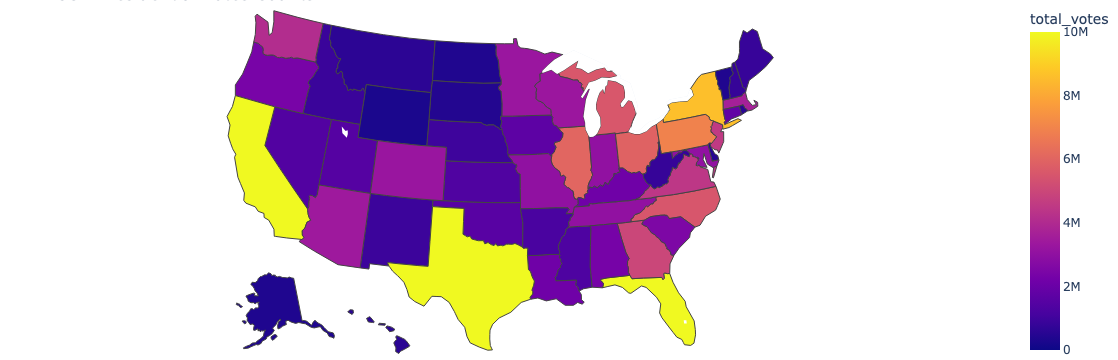

In [194]:
fig = px.choropleth(datafile, locations='usa_state_code', color="total_votes",
                           range_color=(0, 10000000),
                           locationmode = 'USA-states',
                           scope="usa",
                           title='USA Presidential Votes Counts')

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



Which states had the highest voter turnout? - California


In [197]:
#referennce : https://www.kaggle.com/paultimothymooney/2020-usa-election-vote-percentages-by-state

import warnings
warnings.filterwarnings("ignore")

df_president_county = pd.read_csv('president_county_candidate.csv')
df_president_county = df_president_county[df_president_county.party.isin(['DEM','REP'])]
df_president_county = df_president_county.groupby(['state','party'])["total_votes"].sum()
df_president_county = df_president_county.reset_index()

state_codes = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')
state_codes = state_codes[['usa_state','usa_state_code']]
df_president_county = df_president_county.merge(state_codes, left_on='state', right_on='usa_state')
df_president_county = df_president_county.drop(['usa_state'], axis=1)
df_president_county_dummy = pd.get_dummies(df_president_county['party'])
df_president_county = df_president_county.join(df_president_county_dummy)
df_president_county['DEM_votes'] = df_president_county['DEM'] * df_president_county['total_votes']
df_president_county['REP_votes'] = df_president_county['REP'] * df_president_county['total_votes']
df_president_county = df_president_county.groupby(['state', 'usa_state_code'])[['DEM_votes', 'REP_votes']].sum()
df_president_county = df_president_county.reset_index()
df_president_county['percent_democrat'] = df_president_county['DEM_votes']*100/(df_president_county['REP_votes']+df_president_county['DEM_votes'])
df_president_county['REP_votes_prec'] = df_president_county['REP_votes']*100/ (df_president_county['DEM_votes']+df_president_county['REP_votes'])
df_president_county['DEM_votes_prec'] = df_president_county['DEM_votes']*100/ (df_president_county['DEM_votes']+df_president_county['REP_votes'])
df_president_county['margin'] = df_president_county['DEM_votes_prec']-df_president_county['REP_votes_prec']

In [199]:
df_president_county.head()

state usa_state_code  DEM_votes  REP_votes  percent_democrat  \
0     Alabama             AL     849648    1441168         37.089317   
1      Alaska             AK     153405     189892         44.685797   
2     Arizona             AZ    1672143    1661686         50.156832   
3    Arkansas             AR     423932     760647         35.787567   
4  California             CA   11109764    6005961         64.909690   

   REP_votes_prec  DEM_votes_prec     margin  
0       62.910683       37.089317 -25.821367  
1       55.314203       44.685797 -10.628406  
2       49.843168       50.156832   0.313663  
3       64.212433       35.787567 -28.424867  
4       35.090310       64.909690  29.819380

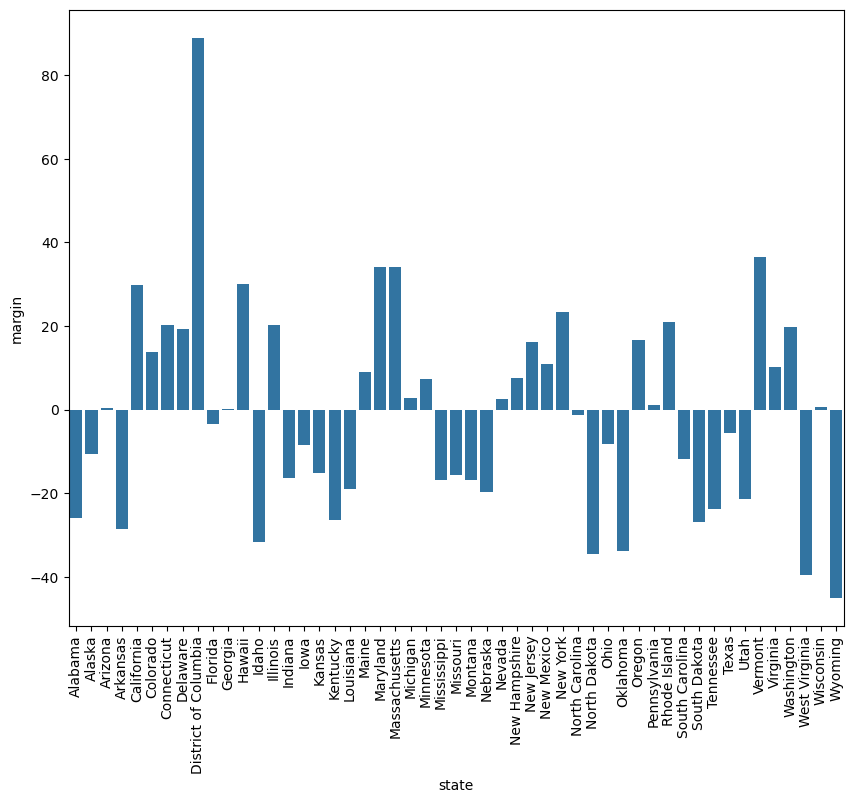

In [201]:
plt.figure(figsize=(10,8))
sns.barplot(x = 'state', y = 'margin', data = df_president_county)
plt.xticks(rotation=90)
plt.show()

* District of Columbia prefers most the democratic party over the republican party.
* Wyoming has the most votes for the republic party.


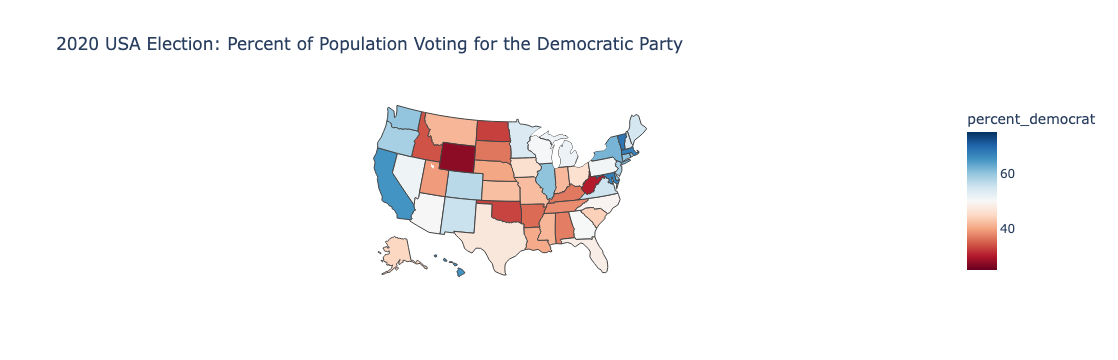

In [203]:
fig = px.choropleth(df_president_county,
                    locations="usa_state_code",
                    color = "percent_democrat",
                    locationmode = 'USA-states',
                    hover_name="state",
                    range_color=[25,75],
                    color_continuous_scale = 'RdBu',#blues
                    scope="usa",
                    title='2020 USA Election: Percent of Population Voting for the Democratic Party')
fig.show()


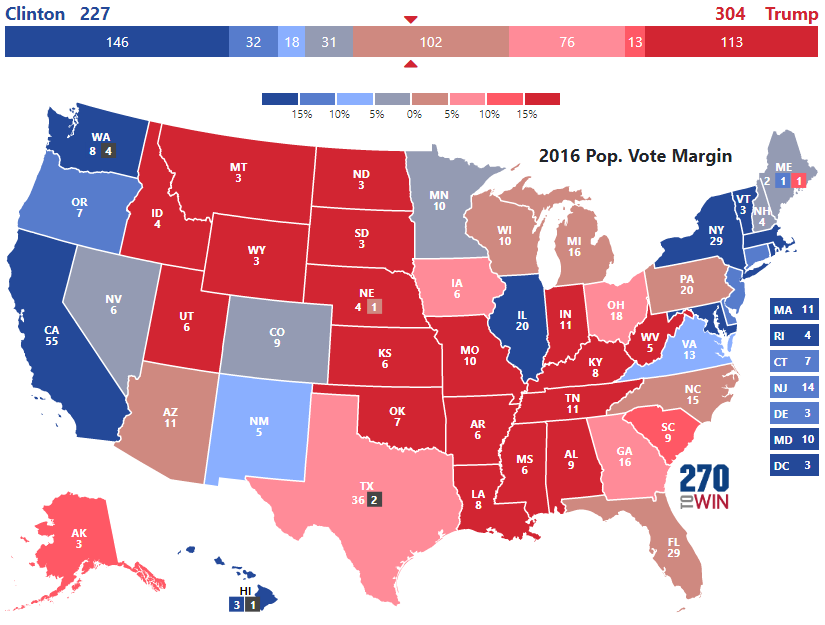

Swing States:
* Arizona (flipped from Republican in 2016 to Democratic in 2020)
* Georgia (flipped from Republican in 2016 to Democratic in 2020)
* Michigan (flipped from Republican in 2016 to Democratic in 2020)
* Pennsylvania (flipped from Republican in 2016 to Democratic in 2020)
* Wisconsin (flipped from Republican in 2016 to Democratic in 2020)




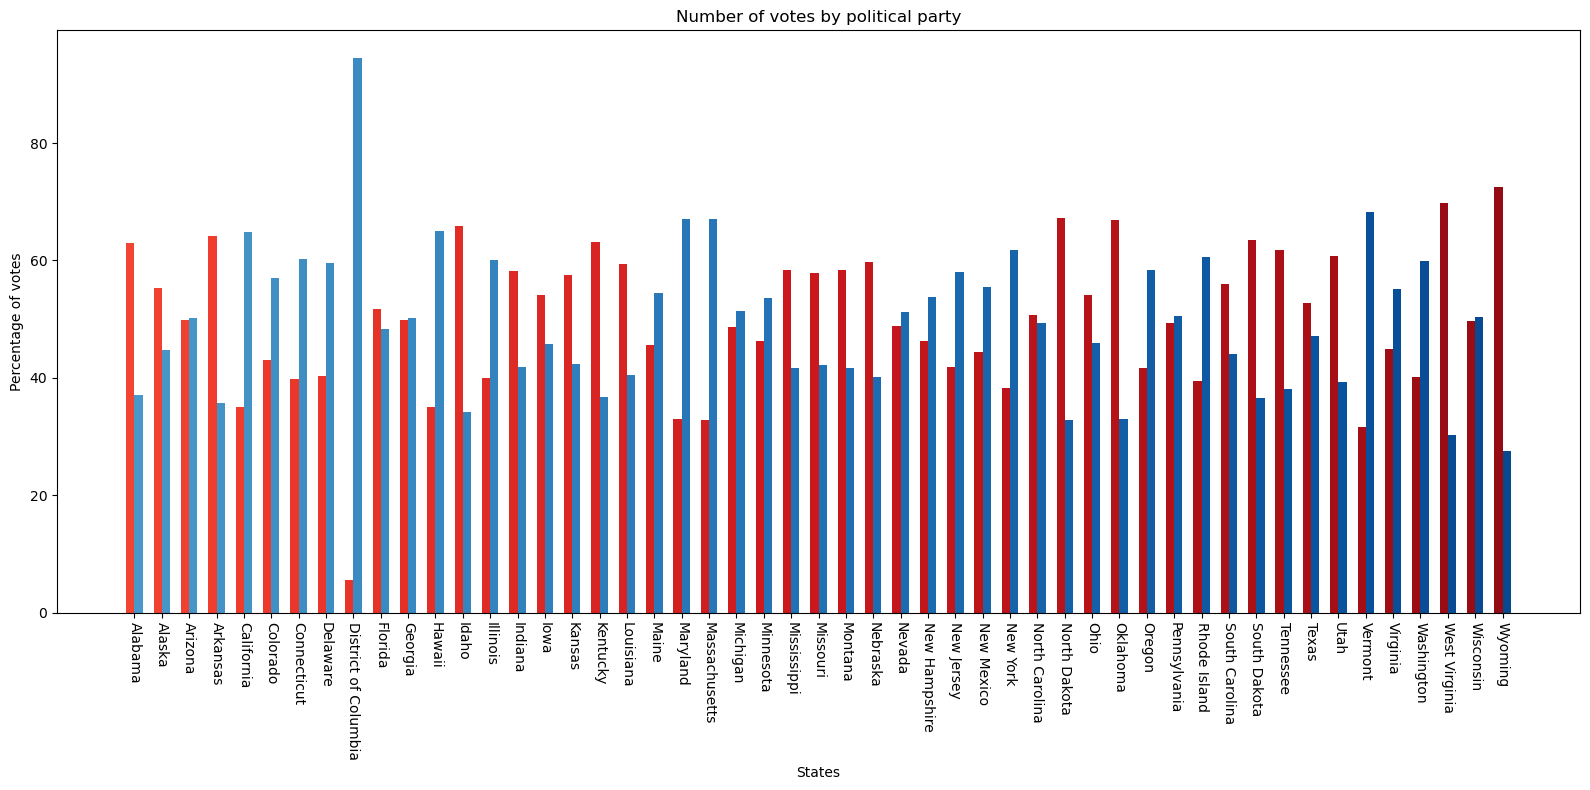

In [208]:
color_1 = plt.cm.Reds(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Blues(np.linspace(0.6, 1, 66))

data1 = df_president_county['REP_votes_prec']
data2 = df_president_county['DEM_votes_prec']

plt.figure(figsize=(16,8))
x = np.arange(len(data1))  # Set x to match the length of data1
state_names = df_president_county['state'] # Assuming data1.index contains state names

ax1 = plt.subplot(1,1,1)
w = 0.3

plt.title('Number of votes by political party')
plt.xticks(x + w / 2, state_names, rotation=-90)  # Use state_names for x-axis labels
ax1.set_xlabel('States')
ax1.set_ylabel('Percentage of votes')

ax1.bar(x, data1.values, color=color_1, width=w, align='center')  # Plot REP votes
ax1.bar(x + w, data2.values, color=color_2, width=w, align='center')  # Plot DEM votes

plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()


In [209]:
df_final = minmax_scaling(df, columns=df.columns)
df_final.head(5)

votes DEM president  votes REP president  \
state   county                                                     
Alabama Autauga County             0.002477             0.017318   
        Baldwin County             0.008115             0.072930   
        Barbour County             0.001590             0.004908   
        Bibb County                0.000656             0.006569   
        Blount County              0.000872             0.021572   

                        votes DEM senate  votes REP senate  \
state   county                                               
Alabama Autauga County          0.021644               0.0   
        Baldwin County          0.075639               0.0   
        Barbour County          0.013130               0.0   
        Bibb County             0.005868               0.0   
        Blount County           0.008603               0.0   

                        votes DEM governors  votes REP governors  TotalPop  \
state   county                                                               
Alabama Autauga County                  0.0                  0.0  0.005446   
        Baldwin County                  0.0                  0.0  0.020123   
        Barbour County                  0.0                  0.0  0.002593   
        Bibb County                     0.0                  0.0  0.002234   
        Blount County                   0.0                  0.0  0.005706   

                             Men     Women  Hispanic  ...  PublicWork  \
state   county                                        ...               
Alabama Autauga County  0.005402  0.005489  0.027218  ...    0.311728   
        Baldwin County  0.019987  0.020256  0.044355  ...    0.199074   
        Barbour County  0.002807  0.002385  0.042339  ...    0.294753   
        Bibb County     0.002460  0.002015  0.024194  ...    0.268519   
        Blount County   0.005721  0.005692  0.090726  ...    0.183642   

                        SelfEmployed  FamilyWork  Unemployment  \
state   county                                                   
Alabama Autauga County      0.147368      0.0125      0.181185   
        Baldwin County      0.165789      0.0125      0.191638   
        Barbour County      0.171053      0.0375      0.432056   
        Bibb County         0.165789      0.0375      0.285714   
        Blount County       0.105263      0.0125      0.170732   

                        votes REP president perc  votes DEM president perc  \
state   county                                                               
Alabama Autauga County                  0.725577                  0.274423   
        Baldwin County                  0.772683                  0.227317   
        Barbour County                  0.538609                  0.461391   
        Bibb County                     0.791189                  0.208811   
        Blount County                   0.903477                  0.096523   

                        votes REP senate perc  votes DEM senate perc  \
state   county                                                         
Alabama Autauga County                    0.0               0.294398   
        Baldwin County                    0.0               0.257182   
        Barbour County                    0.0               0.471765   
        Bibb County                       0.0               0.229706   
        Blount County                     0.0               0.117496   

                        votes REP governors perc  votes DEM governors perc  
state   county                                                              
Alabama Autauga County                       0.0                       0.0  
        Baldwin County                       0.0                       0.0  
        Barbour County                       0.0                       0.0  
        Bibb County                          0.0                       0.0  
        Blount County                        0.0                       0.0  

<Axes: >

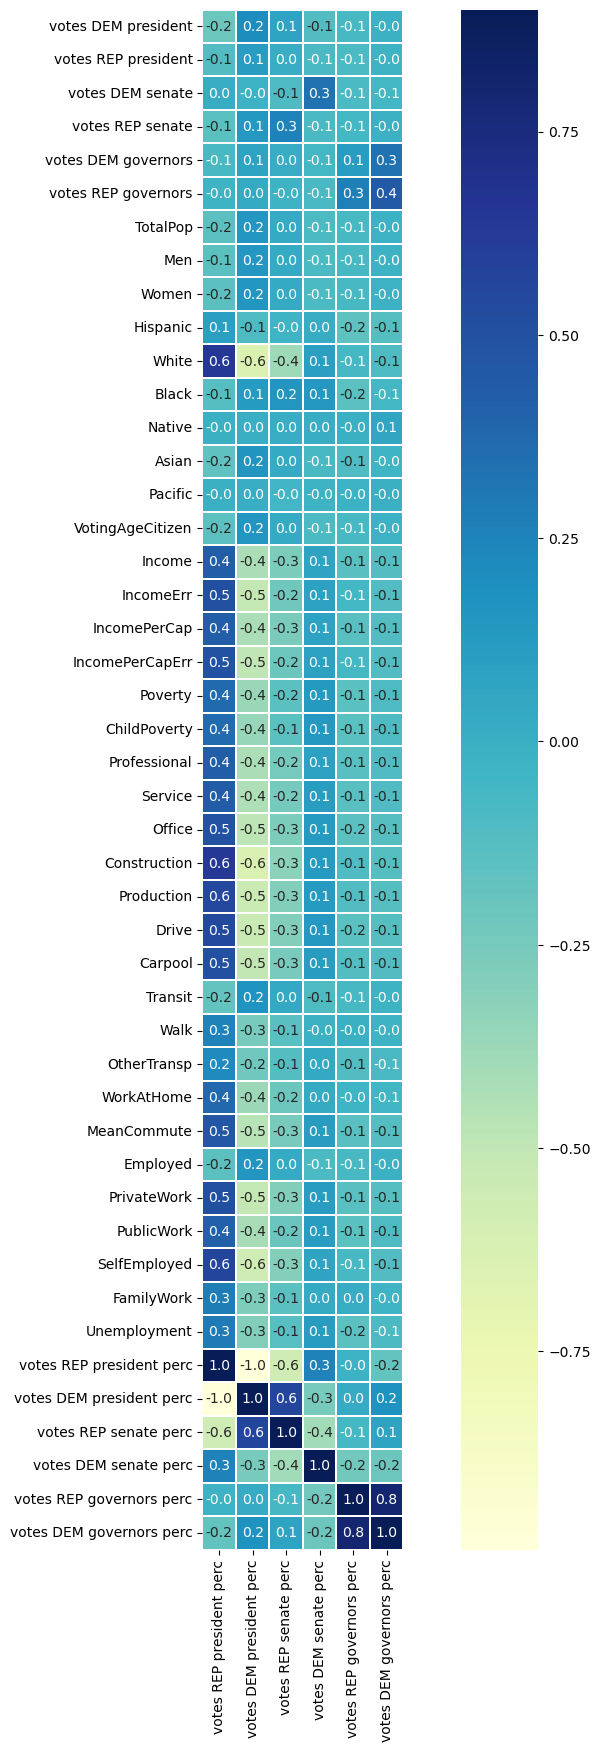

In [212]:
SpearmanCorr = df.corr(method="pearson")
x = SpearmanCorr[votes_perc]
matplotlib.pyplot.figure(figsize=(15,20))
sns.heatmap(x, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

<Axes: >

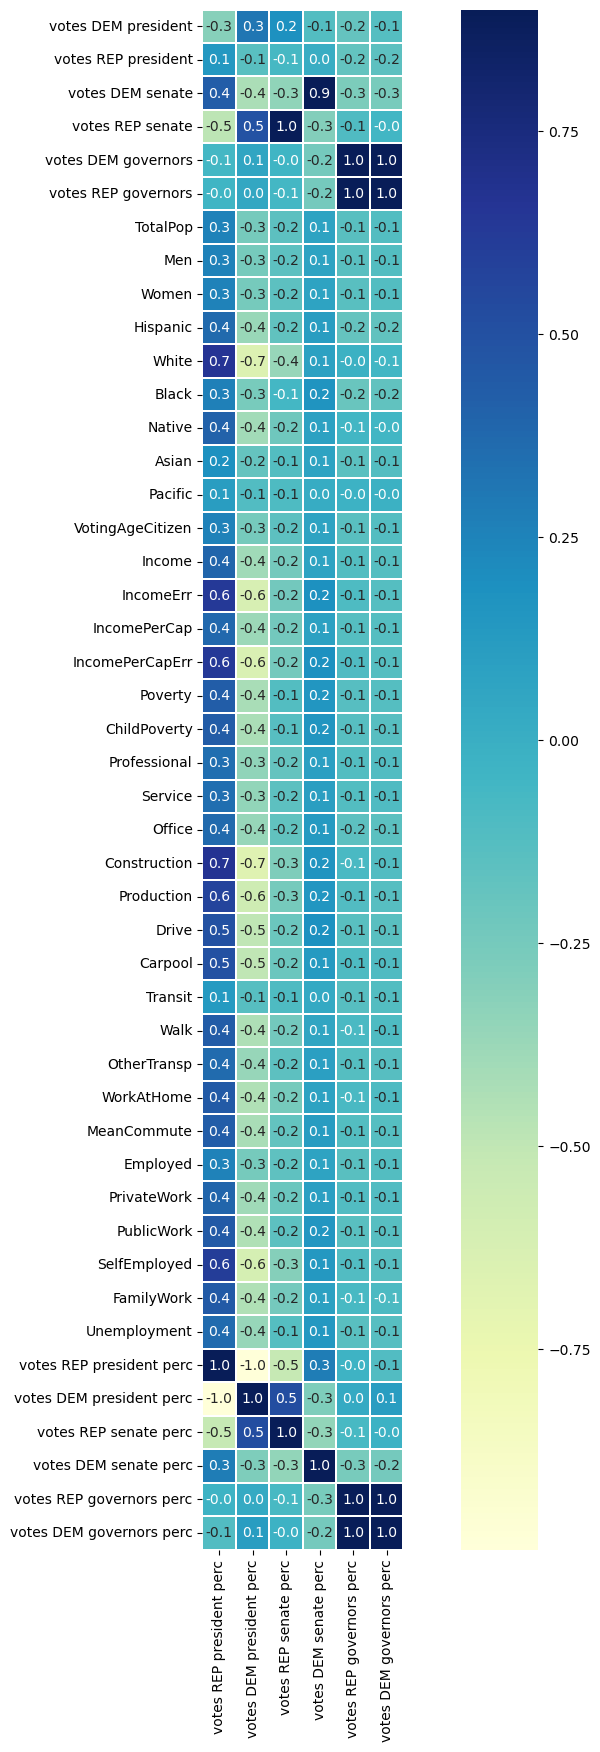

In [213]:
SpearmanCorr = df.corr(method="spearman")
x = SpearmanCorr[votes_perc]
matplotlib.pyplot.figure(figsize=(15,20))
sns.heatmap(x, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

1. Race: White highest votes for the REP party
2. Income: IncomeErr
3. Employment: Employemnt - SelfEmployed..

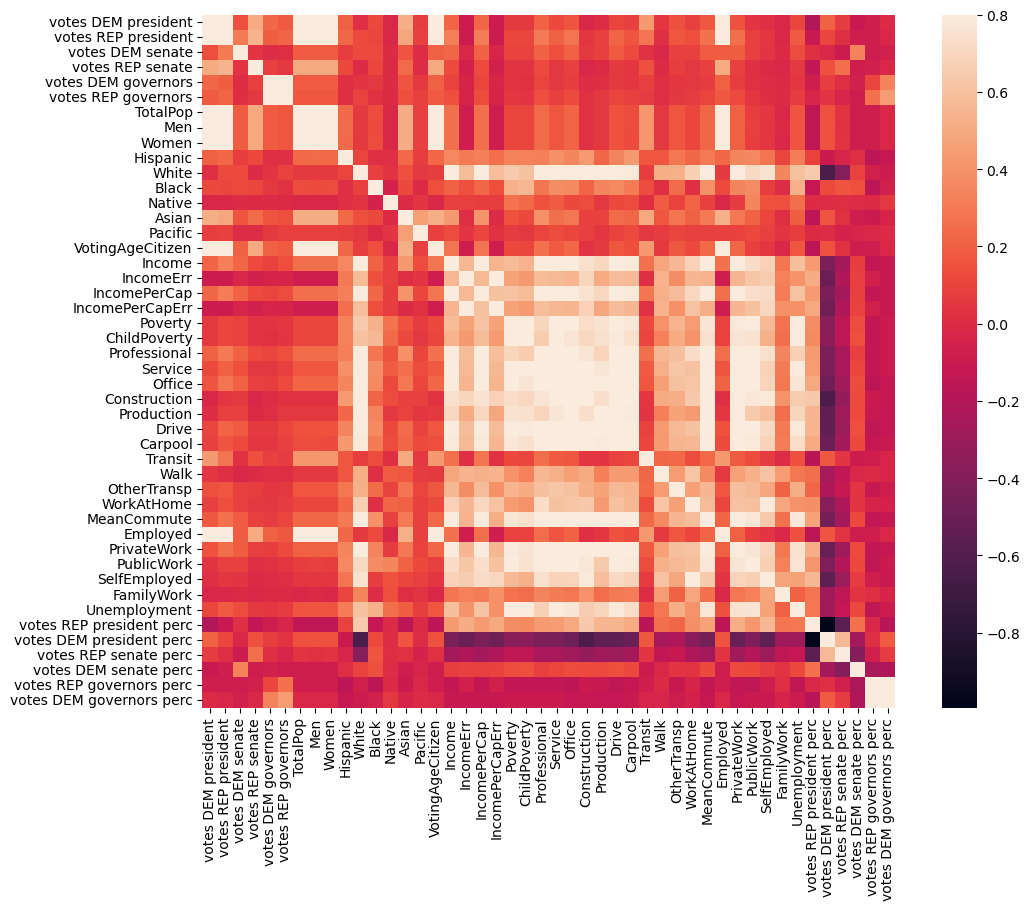

In [216]:
#correlation matrix
corrmat = df_final.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


In [217]:
df.columns

Index(['votes DEM president', 'votes REP president', 'votes DEM senate',
       'votes REP senate', 'votes DEM governors', 'votes REP governors',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'votes REP president perc',
       'votes DEM president perc', 'votes REP senate perc',
       'votes DEM senate perc', 'votes REP governors perc',
       'votes DEM governors perc'],
      dtype='object')

In [219]:
df_final.columns

Index(['votes DEM president', 'votes REP president', 'votes DEM senate',
       'votes REP senate', 'votes DEM governors', 'votes REP governors',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'votes REP president perc',
       'votes DEM president perc', 'votes REP senate perc',
       'votes DEM senate perc', 'votes REP governors perc',
       'votes DEM governors perc'],
      dtype='object')

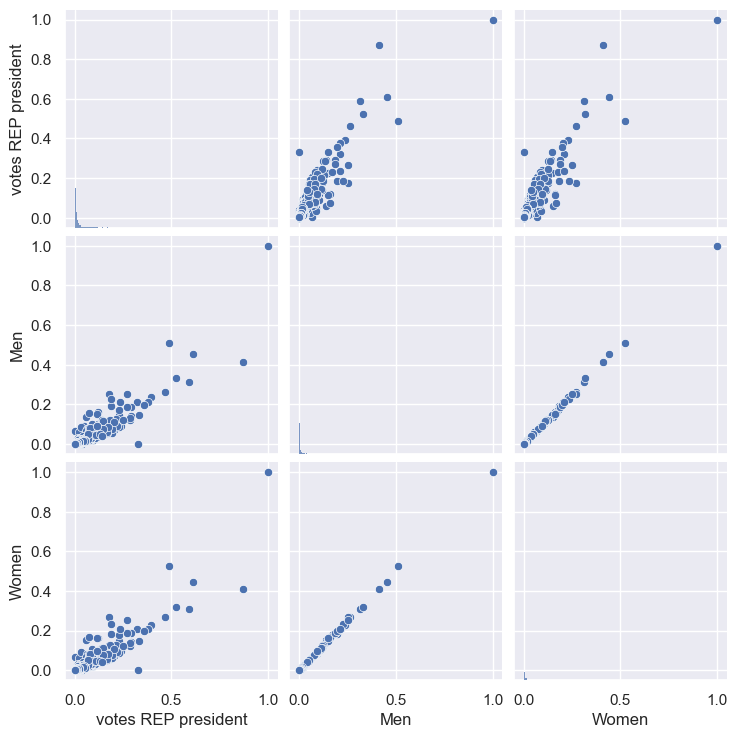

In [220]:
#scatterplot
sns.set()
cols = ['votes REP president', 'Men', 'Women']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

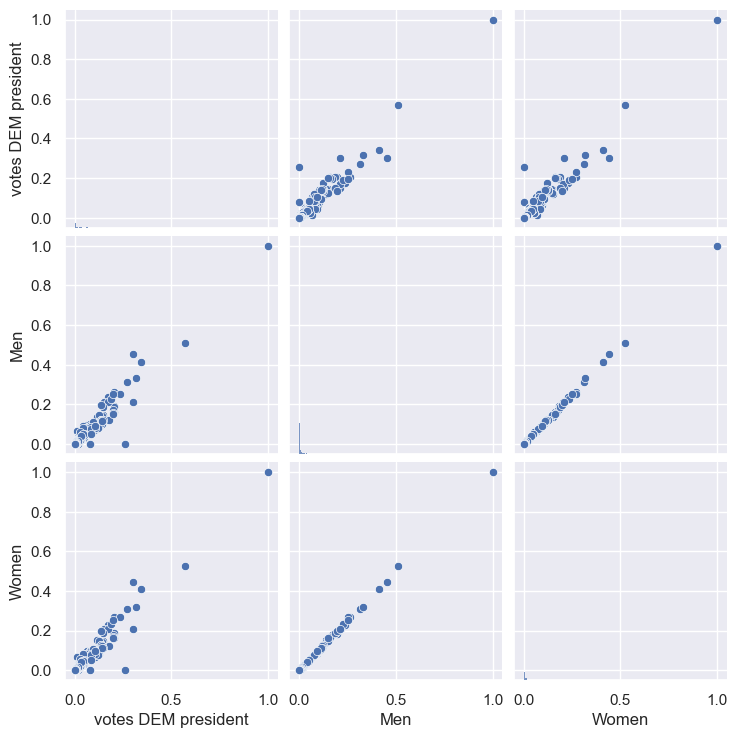

In [224]:
#scatterplot
sns.set()
cols = ['votes DEM president', 'Men', 'Women']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

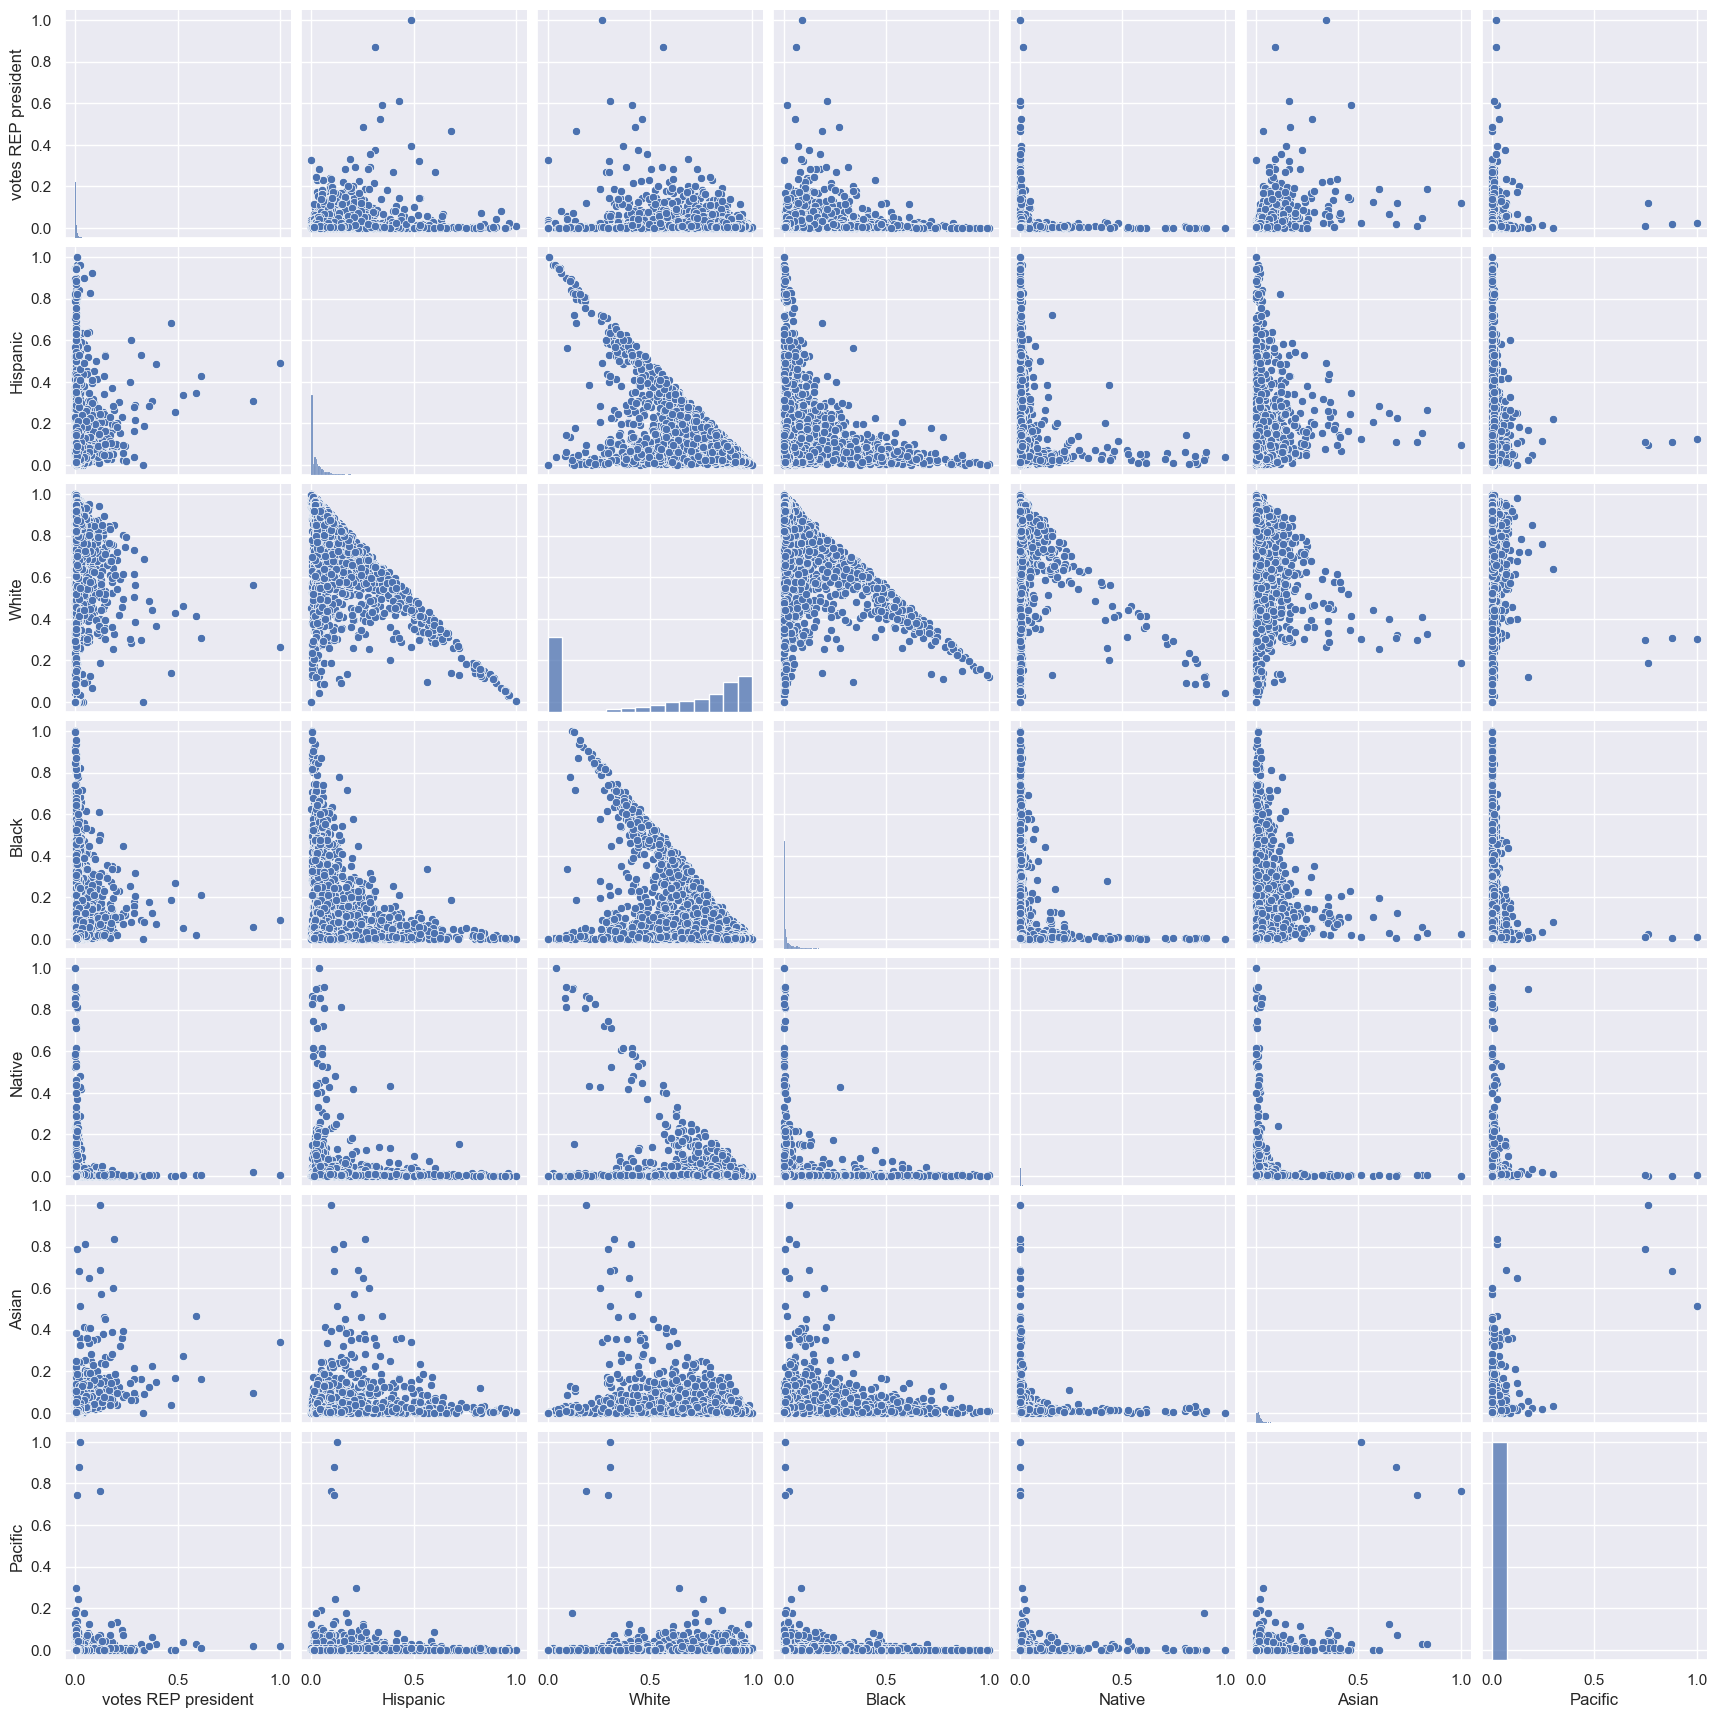

In [225]:
#scatterplot
sns.set()
cols = ['votes REP president', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

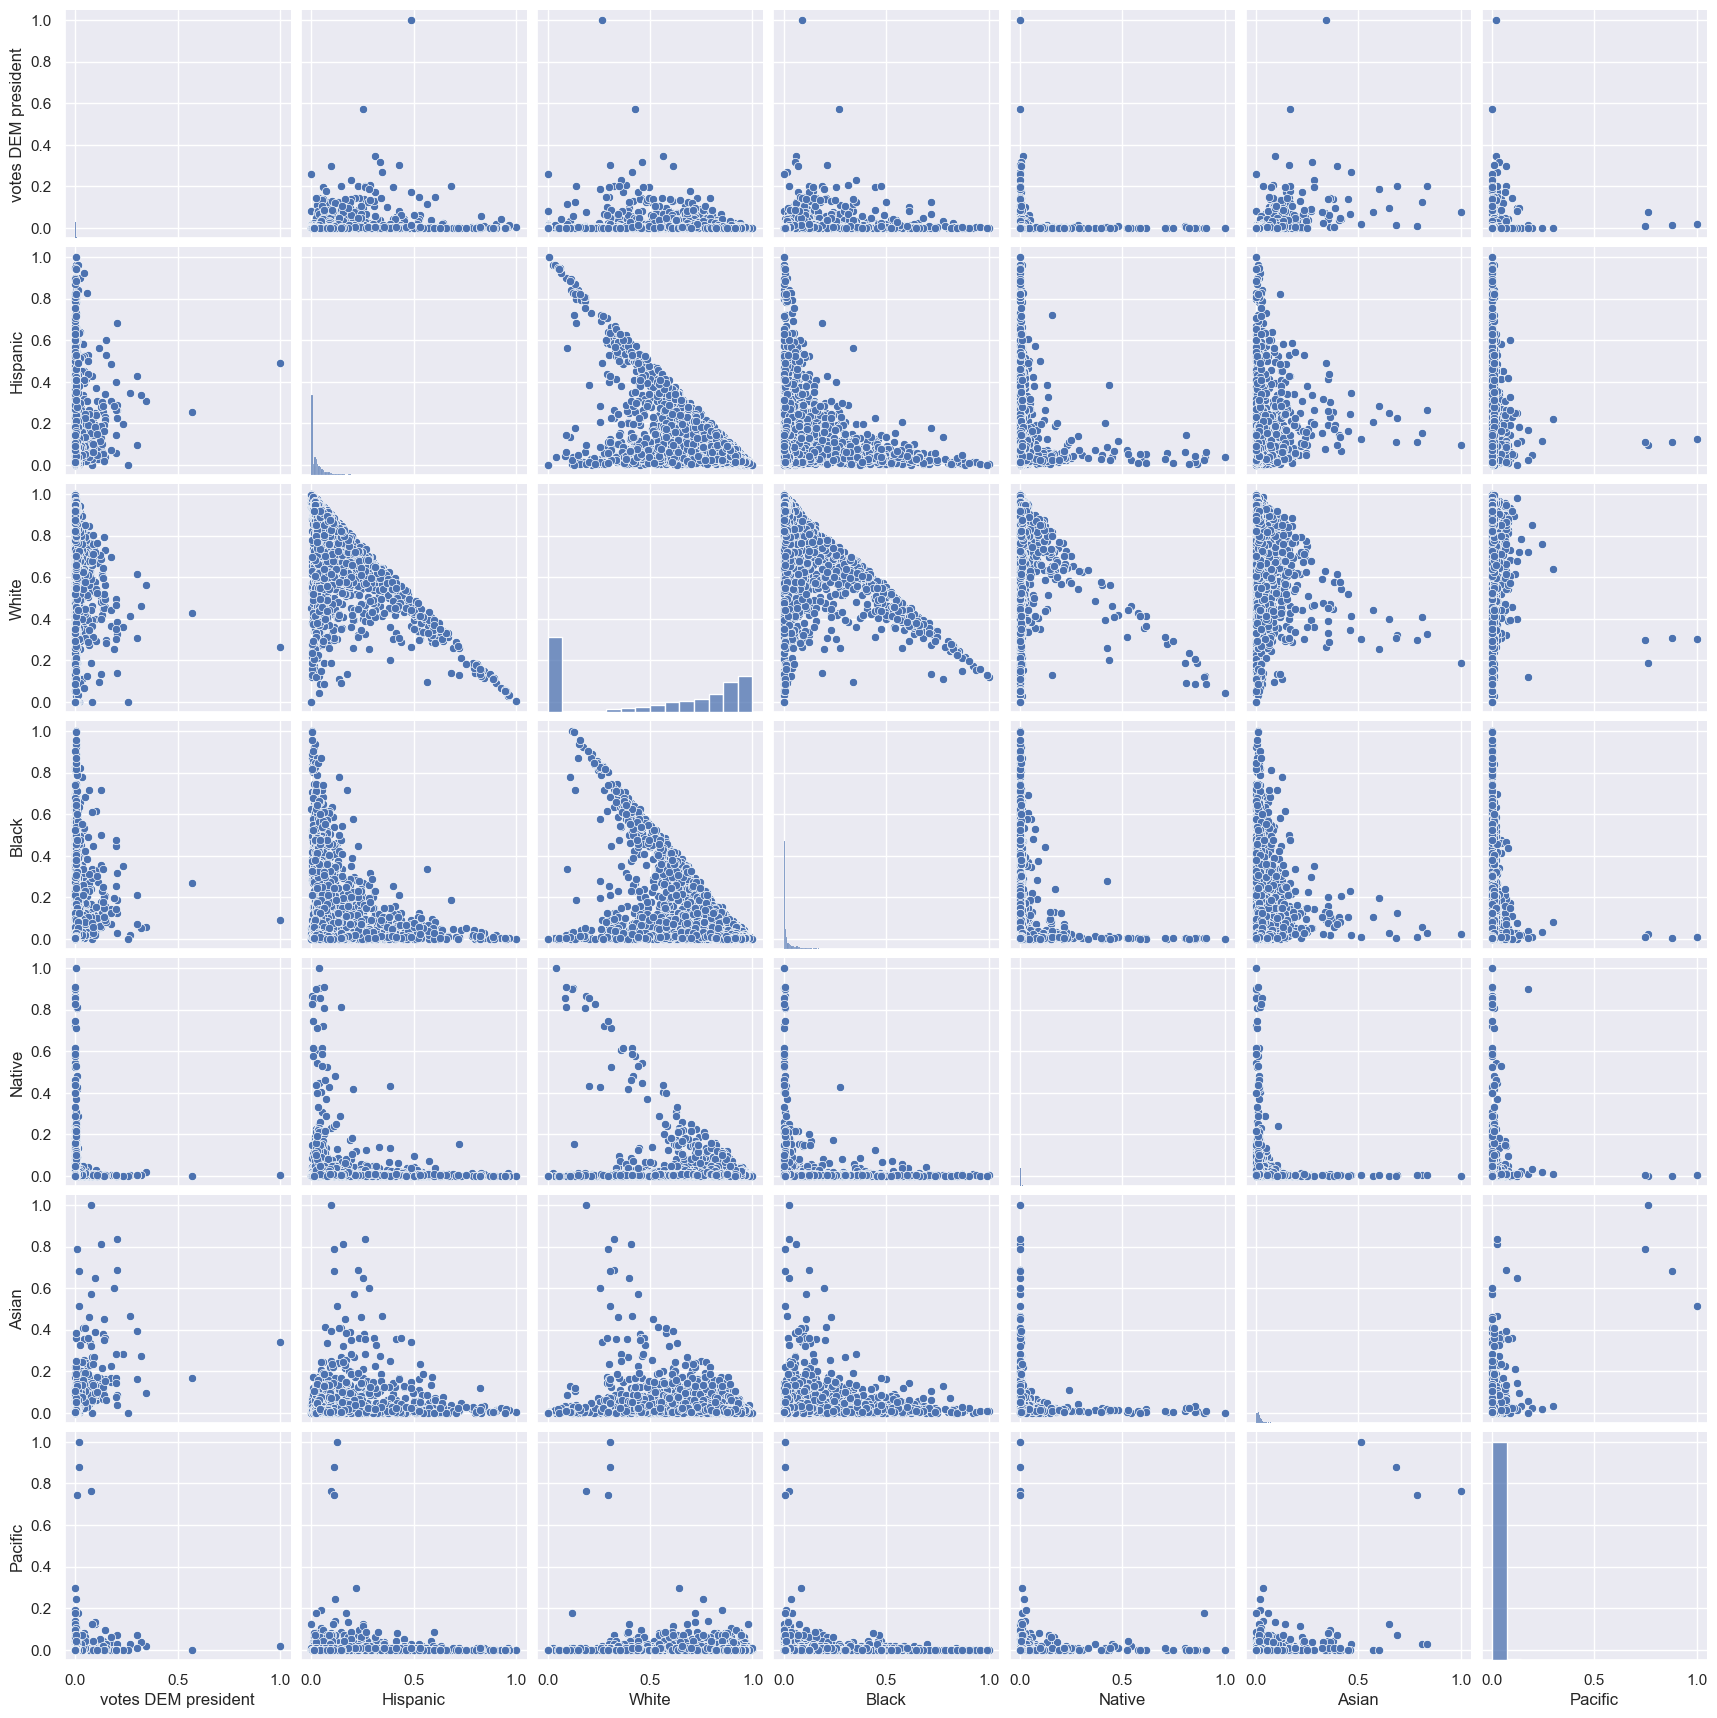

In [226]:
#scatterplot
sns.set()
cols = ['votes DEM president', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

In [227]:
df_final.columns

Index(['votes DEM president', 'votes REP president', 'votes DEM senate',
       'votes REP senate', 'votes DEM governors', 'votes REP governors',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'votes REP president perc',
       'votes DEM president perc', 'votes REP senate perc',
       'votes DEM senate perc', 'votes REP governors perc',
       'votes DEM governors perc'],
      dtype='object')

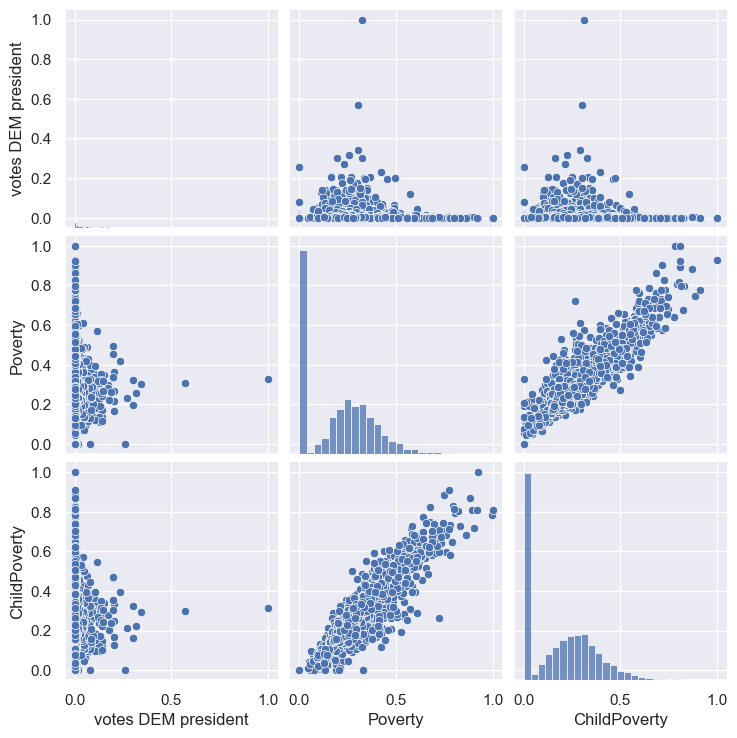

In [228]:
#scatterplot
sns.set()
cols = ['votes DEM president', 'Poverty', 'ChildPoverty']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

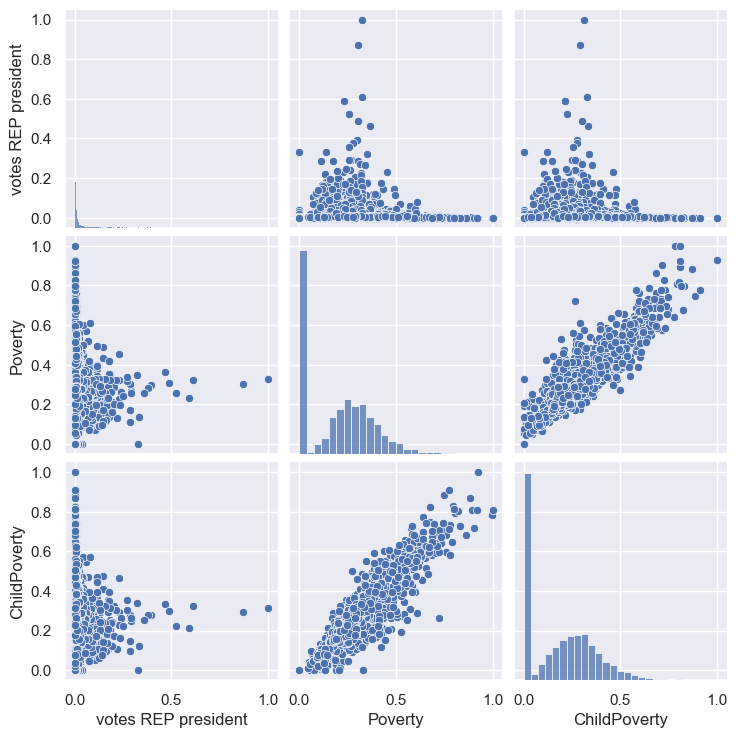

In [229]:
#scatterplot
sns.set()
cols = ['votes REP president', 'Poverty', 'ChildPoverty']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

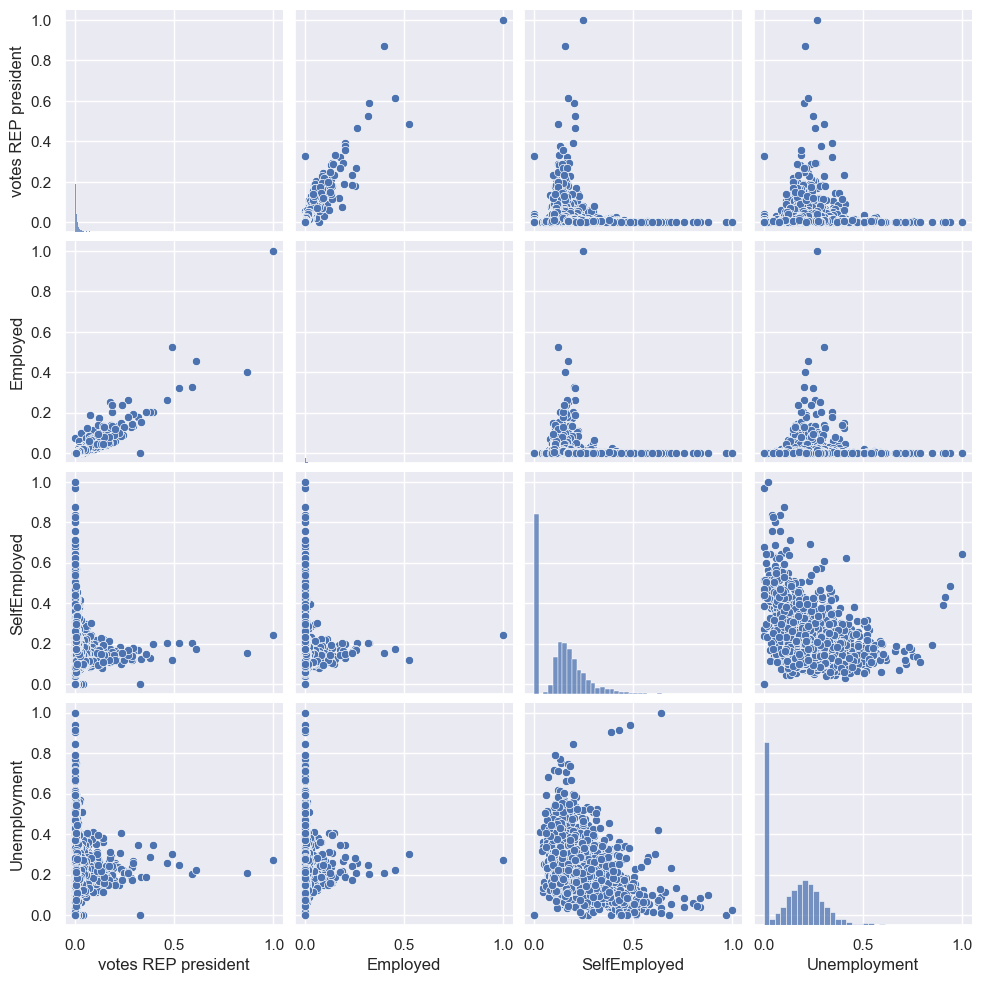

In [230]:
#scatterplot
sns.set()
cols = ['votes REP president', 'Employed', 'SelfEmployed', 'Unemployment']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

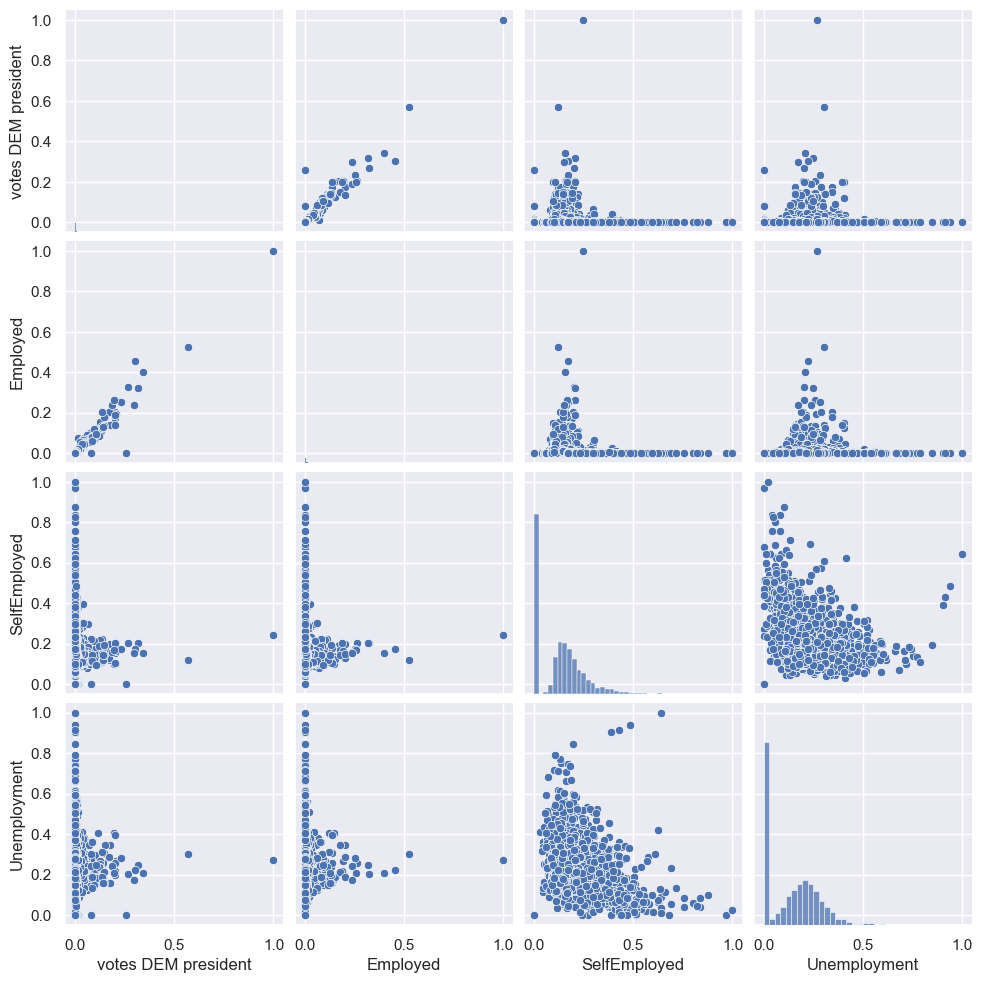

In [231]:
#scatterplot
sns.set()
cols = ['votes DEM president', 'Employed', 'SelfEmployed', 'Unemployment']
sns.pairplot(df_final[cols], size = 2.5)
plt.show();

In [232]:
import pandas as pd
import plotly.express as px

# Load the data
df = pd.read_csv('final_aggregated_data.csv')

# Aggregate data to state level

In [233]:
df.columns

Index(['votes DEM president', 'votes REP president', 'votes DEM senate',
       'votes REP senate', 'votes DEM governors', 'votes REP governors',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'votes REP president perc',
       'votes DEM president perc', 'votes REP senate perc',
       'votes DEM senate perc', 'votes REP governors perc',
       'votes DEM governors perc'],
      dtype='object')

# 3.One-way analysis

Once the data is prepared, cleaned and enriched, I can focus on some visualizations. First, let's scale the data. It will be useful for PCA and clustering in the further part:

In [246]:
df_final = minmax_scaling(df, columns=df.columns)
df_final.head(5)

votes DEM president  votes REP president  votes DEM senate  \
0             0.002477             0.017318          0.021644   
1             0.008115             0.072930          0.075639   
2             0.001590             0.004908          0.013130   
3             0.000656             0.006569          0.005868   
4             0.000872             0.021572          0.008603   

   votes REP senate  votes DEM governors  votes REP governors  TotalPop  \
0               0.0                  0.0                  0.0  0.005446   
1               0.0                  0.0                  0.0  0.020123   
2               0.0                  0.0                  0.0  0.002593   
3               0.0                  0.0                  0.0  0.002234   
4               0.0                  0.0                  0.0  0.005706   

        Men     Women  Hispanic  ...  PublicWork  SelfEmployed  FamilyWork  \
0  0.005402  0.005489  0.027218  ...    0.311728      0.147368      0.0125   
1  0.019987  0.020256  0.044355  ...    0.199074      0.165789      0.0125   
2  0.002807  0.002385  0.042339  ...    0.294753      0.171053      0.0375   
3  0.002460  0.002015  0.024194  ...    0.268519      0.165789      0.0375   
4  0.005721  0.005692  0.090726  ...    0.183642      0.105263      0.0125   

   Unemployment  votes REP president perc  votes DEM president perc  \
0      0.181185                  0.725577                  0.274423   
1      0.191638                  0.772683                  0.227317   
2      0.432056                  0.538609                  0.461391   
3      0.285714                  0.791189                  0.208811   
4      0.170732                  0.903477                  0.096523   

   votes REP senate perc  votes DEM senate perc  votes REP governors perc  \
0                    0.0               0.294398                       0.0   
1                    0.0               0.257182                       0.0   
2                    0.0               0.471765                       0.0   
3                    0.0               0.229706                       0.0   
4                    0.0               0.117496                       0.0   

   votes DEM governors perc  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 46 columns]

Let's look at Spearman correlation: (why not Pearson? [Here explanation](https://www.kaggle.com/jjmewtw/yt-pearson-spearman-distance-corr-rv-coef)):

<Axes: >

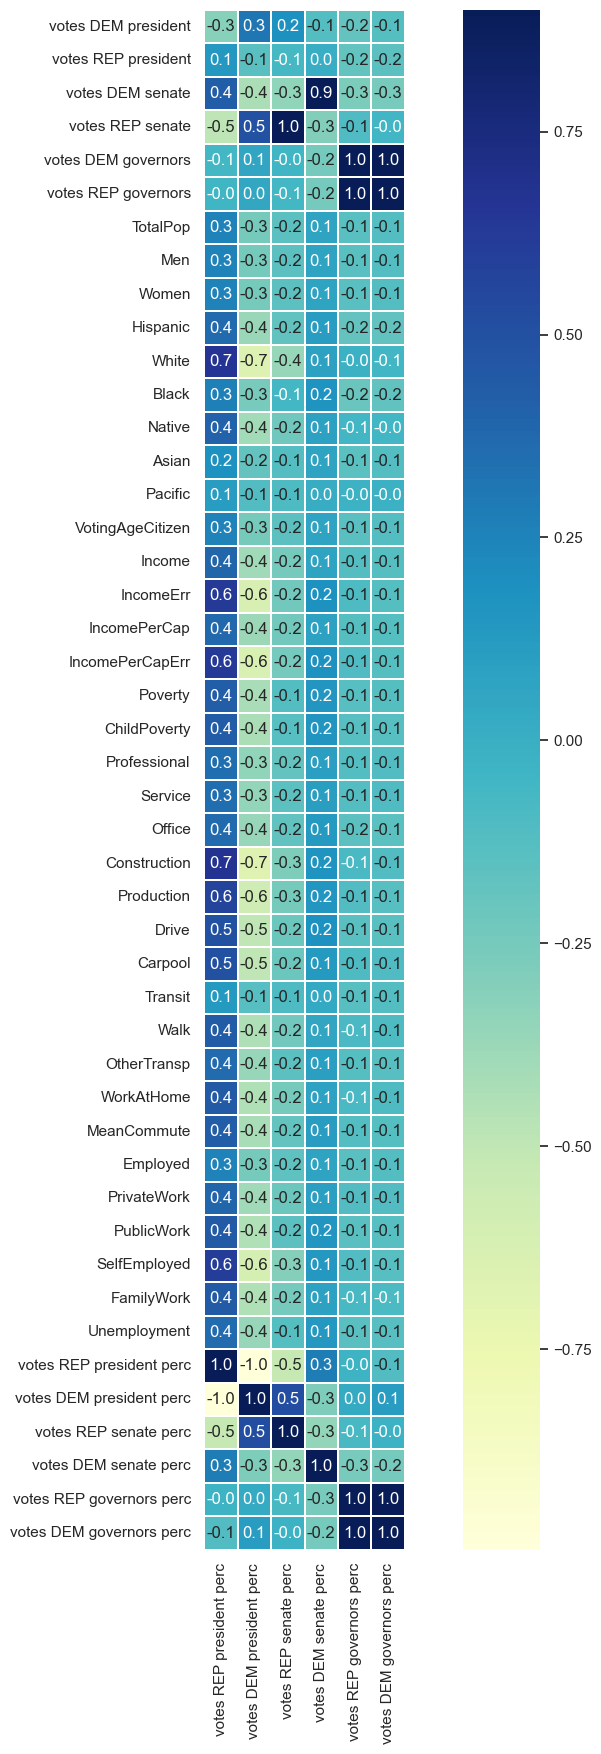

In [249]:
SpearmanCorr = df_final.corr(method="spearman")
x = SpearmanCorr[votes_perc]
matplotlib.pyplot.figure(figsize=(15,20))
sns.heatmap(x, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

Interesting observations:
* Republican president's vote are really correlated with race. He receives votes mostly from white people. Moreover his votes come from people with low income, non self-employed
* Democratic president has majority of correlation perfectly opposite

I plot percentages of votes by states:

In [310]:
df.columns

Index(['votes DEM president', 'votes REP president', 'votes DEM senate',
       'votes REP senate', 'votes DEM governors', 'votes REP governors',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'votes REP president perc',
       'votes DEM president perc', 'votes REP senate perc',
       'votes DEM senate perc', 'votes REP governors perc',
       'votes DEM governors perc'],
      dtype='object')

Wyoming is the Republican paradise, while DC Columbia is democratic one. I look at them also on the map:

In [256]:
pip install basemap

Note: you may need to restart the kernel to use updated packages.


Two big states (California and Texas) remain the centers of power of opposing parties. Middle part of country is kingdom of Republicans. Coasts prefer Democrats. Nothing surprising, but good check whther data makes sense.

# 4.Multi-way

Now I want to look in a bit more granular way. I would like to capture some interesting multi-dimensional trends. First clustering, precisely GM clustering ([more information here](https://www.kaggle.com/jjmewtw/clustering-k-means-hierarchical-debscan-ema)). First, using Akaike I assess what would be the perfect number of clusters. Using legendary 'elbow rule', I would say something like 2 clusters:

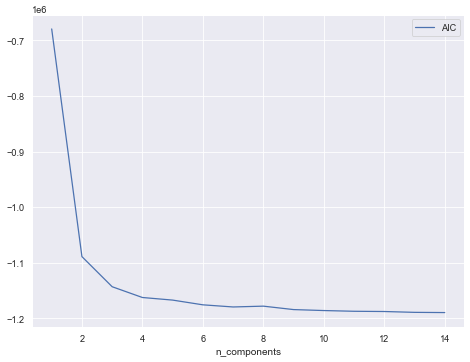

In [260]:
X = df_final[factors].values

GM_n_components = np.arange(1, 15)
GM_models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in GM_n_components]

plt.figure(num=None, figsize=(8, 6), dpi=60, facecolor='w', edgecolor='r')
plt.plot(GM_n_components, [m.aic(X) for m in GM_models], label='AIC')
plt.tight_layout()
plt.legend(loc='best')
plt.xlabel('n_components');


Indeed, as I am interested in finding wheather cluster captures differences between Republicans and Democrats I impose only two of them:

In [262]:
GM_n_classes = 2

GMcluster = mixture.GaussianMixture(n_components=GM_n_classes, covariance_type='full',random_state = 0)
GMcluster_fit = GMcluster.fit(df_final)
GMlabels = GMcluster_fit.predict(df_final)

print('Number of clusters: ' + format(len(np.unique(GMlabels))))

Number of clusters: 2


In [264]:
unique, counts = np.unique(GMlabels, return_counts=True)
dict(zip(unique, counts))

{0: 3044, 1: 1589}

And plotting it in 3 dimensions:

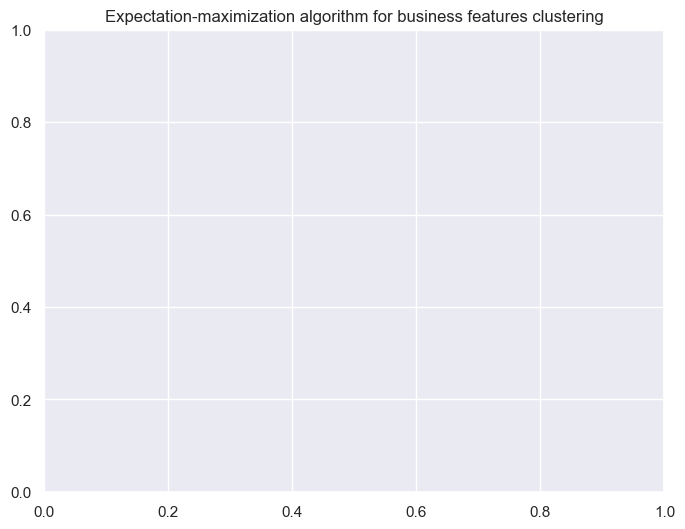

In [267]:
fig = plt.figure(figsize=(8, 6),facecolor='w', edgecolor='r')
ax = p3.Axes3D(fig, rect = (1, 1, 1, 1))
ax.set_xlim3d(0.2, 0.8)
ax.set_ylim3d(0.2, 0.45)
ax.set_zlim3d(0.2, 0.8)
ax.view_init(10, 40)
for l in np.unique(GMlabels):
    ax.scatter(X[GMlabels == l, 0], X[GMlabels == l, 1], X[GMlabels == l, 2],color=plt.cm.jet(float(l) / np.max(GMlabels + 1)),s=20, edgecolor='k')
plt.title('Expectation-maximization algorithm for business features clustering' )

plt.show()

Let's add this cluster to the data, maybe it will be useful:

In [269]:
df_final['Party_Cluster'] = GMlabels

Please notice, that clustering is unsupervised method. It means that I didn't tell it what it tries to predict. It just grouped some behaviours observed in the data.

Next method is PCA ([more information here](https://www.kaggle.com/jjmewtw/total-analysis-of-pca-sparse-pca-nmf-kernel-pca)). I will explore, whether it is possible to create linear transformation of the given data to capture all the infromation. In this case, I use whole data set (votes + demographic), why? I would like to explore whether demographic information is sufficient to capture all trends, or some information is only present in voting data set. The distribution of explained variance:

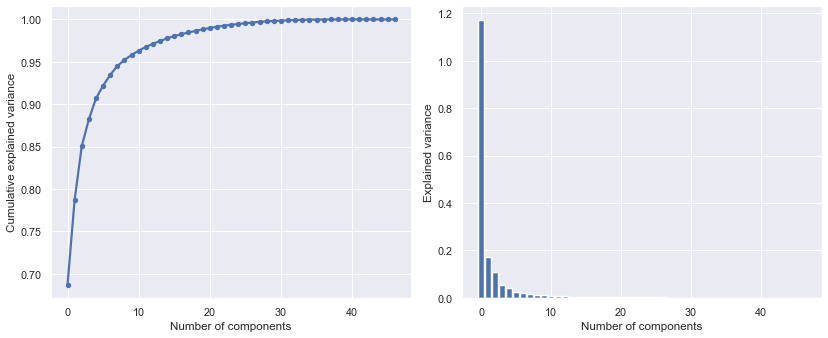

In [272]:
pca = PCA().fit(df_final)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
ax0.set_xlabel('Number of components')
ax0.set_ylabel('Cumulative explained variance');

ax1.bar(range(df_final.shape[1]),pca.explained_variance_)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained variance');

plt.tight_layout()
plt.show()

How many PC's we need:

In [275]:
n_PCA_90 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.9) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.9)
print("Already: " + format(n_PCA_90) + " components cover 90% of variance.")

Already: 4 components cover 90% of variance.


Good result for linear transformation. Breaking it down further. I want to check what variables contribute the most to these top 5 components:

Presenting it in table, only the most contributing variables:

In [282]:
PCA_vars = [0]*len(df_final.columns)

def ExtractColumn(lst,j):
    return [item[j] for item in lst]

for i, feature in zip(range(len(df_final.columns)),df_final.columns):
    x = ExtractColumn(pca.components_,i)
    if ((max(x) > 0.2) | (min(x) < -0.2)):
        if abs(max(x)) > abs(min(x)):
            PCA_vars[i] = max(x)
        else:
            PCA_vars[i] = min(x)
    else:
        PCA_vars[i] = 0

PCA_vars = pd.DataFrame(list(zip(df_final.columns,PCA_vars)),columns=('Name','Max absolute contribution'),index=range(1,48,1))
PCA_vars = (PCA_vars[(PCA_vars['Max absolute contribution']!=0)]).sort_values(by='Max absolute contribution',ascending=False)
PCA_vars

Name  Max absolute contribution
43     votes REP senate perc                   0.856189
45  votes REP governors perc                   0.850426
41  votes REP president perc                   0.463486
11                     White                   0.449759
47             Party_Cluster                   0.436682
46  votes DEM governors perc                   0.431561
26              Construction                   0.210341
44     votes DEM senate perc                  -0.227091
34               MeanCommute                  -0.229364
23              Professional                  -0.230378
40              Unemployment                  -0.238018
19              IncomePerCap                  -0.244619
25                    Office                  -0.256328
17                    Income                  -0.269877
21                   Poverty                  -0.319953
22              ChildPoverty                  -0.347358
28                     Drive                  -0.360414
36               PrivateWork                  -0.371357
12                     Black                  -0.383559
42  votes DEM president perc                  -0.462697

Conclusions:
* a lot of information is present only in voting data set. In other words, it will be hard to predict votes by demographic data
* 'Party cluster' built only on the basis of demographic data is quite useful
* race is a big thing in the data set

# 5.Estimation

Final chapter: I want to predict how republican / democratic given county is on the basis of demographic data. For this I define my response as sum of percentage votes on republican candidates for presidential, senate, governor elections. To keep it between 0 and 1, I scale it. In this way it is easier explainable.

In [300]:
df_final.columns

Index(['votes DEM president', 'votes REP president', 'votes DEM senate',
       'votes REP senate', 'votes DEM governors', 'votes REP governors',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'votes REP president perc',
       'votes DEM president perc', 'votes REP senate perc',
       'votes DEM senate perc', 'votes REP governors perc',
       'votes DEM governors perc', 'Party_Cluster'],
      dtype='object')

In [ ]:
Response = pd.DataFrame(df_final_estimation['votes REP president perc'] + df_final_estimation['votes REP senate perc'] + df_final_estimation['votes REP governors perc'],columns=["Response"])
Response = minmax_scaling(Response, columns=Response.columns)
#df_final['ResponseDEM'] = df_final['votes DEM president perc'] + df_final['votes DEM senate perc'] + df_final['votes DEM governors perc']
df_final_estimation = df_final_estimation.drop(votes, axis=1)
x_train,x_test,y_train,y_test = train_test_split(df_final_estimation,Response,test_size=0.2,random_state=0)

As it is type of best rpactice, my first model is 'average'. I just calculate average value for Repsonse on my train data set:

In [ ]:
ModelAverage = y_train.mean()
print(str(round(ModelAverage,5)))

I define final test data set:

In [ ]:
RMSE = y_test
RMSE.insert(1, "Model_Average", ModelAverage.values[0], True)
y_test=y_test.drop(['Model_Average'], axis=1)
RMSE.head(5)

First real model will be Generalized Linear Model. Let's assume Gaussianity for time being:

In [ ]:
Model_GLM = sm.GLM(y_train, x_train,family=sm.families.Gaussian())

Model_GLM_fit = Model_GLM.fit()

print(Model_GLM_fit.summary())

Also added to the test data set:

In [ ]:
RMSE.insert(2, "Model_GLM", Model_GLM_fit.predict(x_test).values, True)

Further, one of the most popular models in Kaggle: extreme boosting. For this I define my own cross validation with the given space and CV function:

In [ ]:
space={ 'max_depth': hp.quniform("max_depth", 2,25,1),
        'alpha': hp.uniform ('alpha', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 25, 1),
        'learning_rate' : hp.uniform('learning_rate', 0.00001, 0.8),
        'n_estimators': 500,
        'seed': 0}

def f_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def objective(space):
    clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), alpha = space['alpha'],
                        learning_rate = space['learning_rate'],min_child_weight=space['min_child_weight'],colsample_bytree=space['colsample_bytree'])

    evaluation = [( x_train, y_train), ( x_test, y_test)]

    clf_fit = clf.fit(x_train, y_train,verbose=False,eval_set=evaluation,early_stopping_rounds=20)

    pred = clf_fit.predict(x_test)
    score = f_rmse(RMSE['Response'].values, pred)
    print(format(score))
    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest,max_evals = 100,trials = trials)

I print best hyperparameters:

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

And include them to calibrated xgb:

In [ ]:
Model_XGB = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7046466436203225, learning_rate = 0.02192155309970599,
                max_depth = 16, alpha = 0.4135415520098815, n_estimators = 300,min_child_weight=14)

Model_XGB_fit = Model_XGB.fit(x_train,y_train)

Plotting the tree as an example:

In [ ]:
xgb.plot_tree(Model_XGB_fit,num_trees=0)
plt.rcParams['figure.figsize'] = [80,50]
plt.show()

And importance. One can compare it with GLM importance:

In [ ]:
xgb.plot_importance(Model_XGB_fit)
plt.rcParams['figure.figsize'] = [12, 10]
plt.show()

Race is a big thing again. I add these reults to the main table:

In [ ]:
RMSE.insert(3, 'Model_XGB', Model_XGB_fit.predict(x_test), True)
RMSE.head(5)

Add the end I look at RMSE (Root Mean Square Error):

To sum up: extreme boosting performs the best, that's true. But still for example difference between GLM and just average is neglectable. Probably because Gaussianity is wrong assumption, also the link is identical, I could think about some calibration of GLM. All in all, we can see that we can more less predict how counties vote, but the margin of error is really big.

**Please upvote if you like it :)**

Prediction with Data Gathered from https://projects.fivethirtyeight.com/polls/   and    https://www.fec.gov/introduction-campaign-finance/election-results-and-voting-information/

In [95]:
import pandas as pd

polls_24 = pd.read_csv('presidential_general_averages.csv')
polls_20 = pd.read_csv('presidential_poll_averages_2020.csv')
polls_until_16 = pd.read_csv('pres_pollaverages_1968-2016.csv')

In [97]:
polls_until_16.head()

cycle     state modeldate candidate_name  candidate_id  pct_estimate  \
0   2016   Alabama  3/3/2016   Donald Trump          9849      70.11138   
1   2016    Alaska  3/3/2016   Donald Trump          9849      51.63014   
2   2016   Arizona  3/3/2016   Donald Trump          9849      44.00000   
3   2016  Colorado  3/3/2016   Donald Trump          9849      45.95150   
4   2016   Florida  3/3/2016   Donald Trump          9849      46.54603   

   pct_trend_adjusted             timestamp                 comment  \
0            68.63747  18:51:39 14 Jun 2020  full archive 1968-2016   
1            49.68174  18:51:39 14 Jun 2020  full archive 1968-2016   
2            41.02212  18:51:39 14 Jun 2020  full archive 1968-2016   
3            43.51193  18:51:39 14 Jun 2020  full archive 1968-2016   
4            44.68674  18:51:39 14 Jun 2020  full archive 1968-2016   

  election_date  ...  _defaultbasetime  _numloops _state_houseeffects_weight  \
0     11/8/2016  ...                20          5                        0.5   
1     11/8/2016  ...                20          5                        0.5   
2     11/8/2016  ...                20          5                        0.5   
3     11/8/2016  ...                20          5                        0.5   
4     11/8/2016  ...                20          5                        0.5   

   _state_trendline_weight  _out_of_state_house_discount  \
0                      0.5                          0.02   
1                      0.5                          0.02   
2                      0.5                          0.02   
3                      0.5                          0.02   
4                      0.5                          0.02   

   _house_effects_multiplier  _attenuate_endpoints  \
0                          1                   yes   
1                          1                   yes   
2                          1                   yes   
3                          1                   yes   
4                          1                   yes   

   _nonlinear_polynomial_degree  _shortpoly_combpoly_weight  \
0                             2                         0.8   
1                             2                         0.8   
2                             2                         0.8   
3                             2                         0.8   
4                             2                         0.8   

   _nat_shortpoly_combpoly_weight  
0                             0.5  
1                             0.5  
2                             0.5  
3                             0.5  
4                             0.5  

[5 rows x 32 columns]

In [99]:
polls_20.head()

cycle          state  modeldate       candidate_name  pct_estimate  \
0   2020        Wyoming  11/3/2020  Joseph R. Biden Jr.      30.81486   
1   2020      Wisconsin  11/3/2020  Joseph R. Biden Jr.      52.12642   
2   2020  West Virginia  11/3/2020  Joseph R. Biden Jr.      33.49125   
3   2020     Washington  11/3/2020  Joseph R. Biden Jr.      59.34201   
4   2020       Virginia  11/3/2020  Joseph R. Biden Jr.      53.74120   

   pct_trend_adjusted  
0            30.82599  
1            52.09584  
2            33.51517  
3            59.39408  
4            53.72101

In [101]:
polls_24 = polls_24[polls_24['cycle'] == 2024]
polls_until_20 = pd.concat([polls_20, polls_until_16], ignore_index=True)

polls_24['date'] = pd.to_datetime(polls_24['date'], format='%Y-%m-%d')
polls_until_20['modeldate'] = pd.to_datetime(polls_until_20['modeldate'])

In [103]:
polls_until_20 = polls_until_20[['cycle', 'state', 'modeldate', 'candidate_name', 'pct_estimate', 'pct_trend_adjusted']]

In [105]:
results_until_20 = pd.read_csv('results.csv', sep=';')

In [107]:
results_until_20.head()

cycle       state party     candidate   vote_share  Unnamed: 5  Unnamed: 6  \
0   2012     Alabama   DEM  Barack Obama   38,3590331         NaN         NaN   
1   2012      Alaska   DEM  Barack Obama  40,81265911         NaN         NaN   
2   2012     Arizona   DEM  Barack Obama  44,58976694         NaN         NaN   
3   2012    Arkansas   DEM  Barack Obama   36,8789903         NaN         NaN   
4   2012  California   DEM  Barack Obama  60,23895914         NaN         NaN   

   Unnamed: 7  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [109]:
results_until_20 = results_until_20[['cycle', 'state', 'party', 'candidate', 'vote_share']]

In [111]:
results_until_20.head()

cycle       state party     candidate   vote_share
0   2012     Alabama   DEM  Barack Obama   38,3590331
1   2012      Alaska   DEM  Barack Obama  40,81265911
2   2012     Arizona   DEM  Barack Obama  44,58976694
3   2012    Arkansas   DEM  Barack Obama   36,8789903
4   2012  California   DEM  Barack Obama  60,23895914

In [113]:
polls_until_16=polls_until_16[polls_until_16['cycle']>=2000]

In [115]:
swing_states = [
    'Pennsylvania', 'Wisconsin', 'Michigan', 'Georgia',
    'North Carolina', 'Arizona', 'Nevada'
]
blue_states = [
    'District of Columbia', 'Vermont', 'Massachusetts', 'Maryland',
    'Hawaii', 'California', 'ME-1', 'Connecticut', 'Washington',
    'Delaware', 'Rhode Island', 'New York', 'Illinois', 'New Jersey',
    'Oregon', 'Colorado', 'Maine', 'New Mexico', 'Virginia',
    'New Hampshire', 'NE-2', 'Minnesota'
]
red_states = [
    'Wyoming', 'West Virginia', 'Oklahoma', 'North Dakota',
    'Idaho', 'South Dakota', 'Arkansas', 'Kentucky', 'NE-3',
    'Alabama', 'Tennessee', 'Utah', 'Louisiana', 'Nebraska',
    'Mississippi', 'Montana', 'NE-1', 'Indiana', 'Kansas',
    'Missouri', 'South Carolina', 'Alaska', 'Ohio', 'Iowa',
    'Texas', 'ME-2', 'Florida'
]

swing_until_20 = polls_until_20[polls_until_20['state'].isin(swing_states)]
swing_24 = polls_24[polls_24['state'].isin(swing_states)]

In [117]:
swing_24.isnull().sum()

candidate                0
date                     0
pct_trend_adjusted    3736
state                    0
cycle                    0
party                    0
pct_estimate             0
hi                       0
lo                       0
dtype: int64

In [119]:
swing_until_20.isnull().sum()

cycle                  0
state                  0
modeldate             12
candidate_name         0
pct_estimate           0
pct_trend_adjusted     0
dtype: int64

In [121]:
swing_until_20= swing_until_20[~swing_until_20['candidate_name'].str.startswith('Convention Bounce')]

In [123]:
candidate_names = swing_until_20['candidate_name'].unique().tolist()

In [125]:
party_map = {
    'Joseph R. Biden Jr.': 'DEM',
    'Donald Trump': 'REP',
    'Hillary Rodham Clinton': 'DEM',
    'Gary Johnson': 'LIB',
    'Barack Obama': 'DEM',
    'Mitt Romney': 'REP',
    'John McCain': 'REP',
    'Ralph Nader': 'IND',
    'George W. Bush': 'REP',
    'John Kerry': 'DEM',
    'Al Gore': 'DEM'
}

In [127]:
candidate_df= pd.DataFrame(candidate_names,columns=['candidate_name'])

In [129]:
candidate_df['party']= candidate_df['candidate_name'].map(party_map)

In [131]:
swing_until_20= swing_until_20.merge(candidate_df,on='candidate_name',how='left')

In [133]:
swing_until_20

cycle           state  modeldate       candidate_name  pct_estimate  \
0       2020       Wisconsin 2020-11-03  Joseph R. Biden Jr.      52.12642   
1       2020    Pennsylvania 2020-11-03  Joseph R. Biden Jr.      50.22000   
2       2020  North Carolina 2020-11-03  Joseph R. Biden Jr.      48.90633   
3       2020          Nevada 2020-11-03  Joseph R. Biden Jr.      49.62386   
4       2020        Michigan 2020-11-03  Joseph R. Biden Jr.      51.17806   
...      ...             ...        ...                  ...           ...   
34754   1972  North Carolina 1972-11-07     Richard M. Nixon      65.62482   
34755   1972    Pennsylvania 1972-11-07     Richard M. Nixon      58.18247   
34756   1972        Michigan 1972-11-07   George S. McGovern      40.82501   
34757   1972  North Carolina 1972-11-07   George S. McGovern      24.29243   
34758   1972    Pennsylvania 1972-11-07   George S. McGovern      38.61049   

       pct_trend_adjusted party  
0                52.09584   DEM  
1                50.20422   DEM  
2                48.90359   DEM  
3                49.65657   DEM  
4                51.15482   DEM  
...                   ...   ...  
34754            63.38094   NaN  
34755            58.04797   NaN  
34756            41.35538   NaN  
34757            28.73580   NaN  
34758            39.49675   NaN  

[34759 rows x 7 columns]

In [135]:
swing_until_20 = pd.merge(swing_until_20, results_until_20, how='left', left_on=['cycle', 'state', 'party', 'candidate_name'], right_on=['cycle', 'state', 'party', 'candidate'])

In [137]:
swing_until_20.head()

cycle           state  modeldate       candidate_name  pct_estimate  \
0   2020       Wisconsin 2020-11-03  Joseph R. Biden Jr.      52.12642   
1   2020    Pennsylvania 2020-11-03  Joseph R. Biden Jr.      50.22000   
2   2020  North Carolina 2020-11-03  Joseph R. Biden Jr.      48.90633   
3   2020          Nevada 2020-11-03  Joseph R. Biden Jr.      49.62386   
4   2020        Michigan 2020-11-03  Joseph R. Biden Jr.      51.17806   

   pct_trend_adjusted party            candidate   vote_share  
0            52.09584   DEM  Joseph R. Biden Jr.  49,44953686  
1            50.20422   DEM  Joseph R. Biden Jr.  49,85211135  
2            48.90359   DEM  Joseph R. Biden Jr.  48,58619419  
3            49.65657   DEM  Joseph R. Biden Jr.  50,05678196  
4            51.15482   DEM  Joseph R. Biden Jr.  50,62081829

In [139]:
swing_until_20['vote_share'] = swing_until_20['vote_share'].str.replace(',', '.')
swing_until_20['vote_share'] = pd.to_numeric(swing_until_20['vote_share'])

In [141]:
swing_until_20.rename(columns={'modeldate': 'date'}, inplace=True)

In [143]:
swing_24.head()

candidate       date  pct_trend_adjusted    state  cycle party  \
21300     Trump 2024-09-12                 NaN  Arizona   2024   REP   
21301    Harris 2024-09-12                 NaN  Arizona   2024   DEM   
21302     Trump 2024-09-11                 NaN  Arizona   2024   REP   
21303    Harris 2024-09-11                 NaN  Arizona   2024   DEM   
21304     Trump 2024-09-10                 NaN  Arizona   2024   REP   

       pct_estimate         hi         lo  
21300      46.15125  47.713017  44.562177  
21301      45.55990  47.205612  43.831088  
21302      46.21710  47.876045  44.674330  
21303      45.44870  47.142852  43.790568  
21304      46.24450  47.917710  44.695253

In [145]:
swing_24 = swing_24[['cycle', 'date', 'state', 'party', 'candidate', 'pct_estimate']]
swing_until_20 = swing_until_20[['cycle', 'date', 'state', 'party', 'candidate', 'pct_estimate', 'vote_share']]

In [147]:
swing_24['candidate'] = swing_24['candidate'].replace({
    'Trump': 'Donald Trump',
    'Biden': 'Joseph R. Biden Jr.',
    'Harris': 'Kamala Harris',
    'Kennedy': 'Robert F. Kennedy'})

In [149]:
srad=swing_24.groupby(['state','cycle','date'])['pct_estimate']

In [151]:
srad.head()

21300    46.15125
21301    45.55990
21302    46.21710
21303    45.44870
21304    46.24450
           ...   
27096    10.28615
27097    38.73255
27098    41.58205
27099    10.30900
27100    38.85280
Name: pct_estimate, Length: 3736, dtype: float64

In [153]:
swing_24['pct_3rd_party'] = swing_24.groupby(['cycle', 'date', 'state'])['pct_estimate'].transform( lambda x: x[~swing_24['party'].isin(['DEM', 'REP'])].sum())
swing_until_20['pct_3rd_party'] = swing_until_20.groupby(['cycle', 'date', 'state'])['pct_estimate'].transform( lambda x: x[~swing_until_20['party'].isin(['DEM', 'REP'])].sum())

In [154]:
swing_24.head()

cycle       date    state party      candidate  pct_estimate  \
21300   2024 2024-09-12  Arizona   REP   Donald Trump      46.15125   
21301   2024 2024-09-12  Arizona   DEM  Kamala Harris      45.55990   
21302   2024 2024-09-11  Arizona   REP   Donald Trump      46.21710   
21303   2024 2024-09-11  Arizona   DEM  Kamala Harris      45.44870   
21304   2024 2024-09-10  Arizona   REP   Donald Trump      46.24450   

       pct_3rd_party  
21300            0.0  
21301            0.0  
21302            0.0  
21303            0.0  
21304            0.0

In [155]:
swing_24 = swing_24[swing_24['party'].isin(['DEM', 'REP'])]
swing_until_20 = swing_until_20[swing_until_20['party'].isin(['DEM', 'REP'])]

In [156]:
swing_24['pct_opponent'] = swing_24.apply(lambda row: swing_24[(swing_24['date'] == row['date']) & (swing_24['state'] == row['state']) & (swing_24['party'] != row['party'])]['pct_estimate'].sum(), axis=1)
swing_until_20['pct_opponent'] = swing_until_20.apply(lambda row: swing_until_20[(swing_until_20['date'] == row['date']) & (swing_until_20['state'] == row['state']) & (swing_until_20['party'] != row['party'])]['pct_estimate'].sum(), axis=1)

swing_24['lead'] = swing_24['pct_estimate'] - swing_24['pct_opponent']
swing_until_20['lead'] = swing_until_20['pct_estimate'] - swing_until_20['pct_opponent']

In [157]:
swing_24.head()

cycle       date    state party      candidate  pct_estimate  \
21300   2024 2024-09-12  Arizona   REP   Donald Trump      46.15125   
21301   2024 2024-09-12  Arizona   DEM  Kamala Harris      45.55990   
21302   2024 2024-09-11  Arizona   REP   Donald Trump      46.21710   
21303   2024 2024-09-11  Arizona   DEM  Kamala Harris      45.44870   
21304   2024 2024-09-10  Arizona   REP   Donald Trump      46.24450   

       pct_3rd_party  pct_opponent     lead  
21300            0.0      45.55990  0.59135  
21301            0.0      46.15125 -0.59135  
21302            0.0      45.44870  0.76840  
21303            0.0      46.21710 -0.76840  
21304            0.0      45.49245  0.75205

In [158]:
election_dates = {
    2000: pd.to_datetime('2000-11-07'),
    2004: pd.to_datetime('2004-11-02'),
    2008: pd.to_datetime('2008-11-04'),
    2012: pd.to_datetime('2012-11-06'),
    2016: pd.to_datetime('2016-11-08'),
    2020: pd.to_datetime('2020-11-03')
}

swing_until_20['election_date'] = swing_until_20['cycle'].map(election_dates)

In [159]:
swing_24['election_date'] = pd.to_datetime('2024-11-05')

swing_24['days_until_election'] = (swing_24['election_date'] - swing_24['date']).dt.days
swing_until_20['days_until_election'] = (swing_until_20['election_date'] - swing_until_20['date']).dt.days

swing_24 = swing_24.sort_values(by='date')
swing_24['rolling_avg_7d'] = swing_24.groupby(['state', 'party'])['pct_estimate'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

swing_until_20 = swing_until_20.sort_values(by='date')
swing_until_20['rolling_avg_7d'] = swing_until_20.groupby(['cycle', 'state', 'party'])['pct_estimate'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

In [160]:
swing_24['momentum_candidate'] = swing_24.groupby(['state', 'party'])['pct_estimate'].diff()
swing_until_20['momentum_candidate'] = swing_until_20.groupby(['state', 'party'])['pct_estimate'].diff()

swing_24['momentum_opponent'] = swing_24.groupby(['state', 'party'])['pct_opponent'].diff()
swing_until_20['momentum_opponent'] = swing_until_20.groupby(['state', 'party'])['pct_opponent'].diff()

swing_24['momentum'] = swing_24['momentum_candidate'] - swing_24['momentum_opponent']
swing_until_20['momentum'] = swing_until_20['momentum_candidate'] - swing_until_20['momentum_opponent']

In [161]:
swing_24.head()

cycle       date         state party            candidate  \
27100   2024 2024-03-01     Wisconsin   DEM  Joseph R. Biden Jr.   
26297   2024 2024-03-01  Pennsylvania   REP         Donald Trump   
26299   2024 2024-03-01  Pennsylvania   DEM  Joseph R. Biden Jr.   
22823   2024 2024-03-01       Arizona   REP         Donald Trump   
22825   2024 2024-03-01       Arizona   DEM  Joseph R. Biden Jr.   

       pct_estimate  pct_3rd_party  pct_opponent     lead election_date  \
27100       38.8528       10.30900      41.58205 -2.72925    2024-11-05   
26297       43.0132        9.45646      39.35610  3.65710    2024-11-05   
26299       39.3561        9.45646      43.01320 -3.65710    2024-11-05   
22823       43.6351       10.83900      38.28310  5.35200    2024-11-05   
22825       38.2831       10.83900      43.63510 -5.35200    2024-11-05   

       days_until_election  rolling_avg_7d  momentum_candidate  \
27100                  249         38.8528                 NaN   
26297                  249         43.0132                 NaN   
26299                  249         39.3561                 NaN   
22823                  249         43.6351                 NaN   
22825                  249         38.2831                 NaN   

       momentum_opponent  momentum  
27100                NaN       NaN  
26297                NaN       NaN  
26299                NaN       NaN  
22823                NaN       NaN  
22825                NaN       NaN

In [162]:
swing_24 = swing_24.dropna()
swing_until_20 = swing_until_20.dropna()

In [163]:
swing_24.head()

cycle       date         state party            candidate  \
27097   2024 2024-03-02     Wisconsin   DEM  Joseph R. Biden Jr.   
25226   2024 2024-03-02        Nevada   REP         Donald Trump   
25228   2024 2024-03-02        Nevada   DEM  Joseph R. Biden Jr.   
26296   2024 2024-03-02  Pennsylvania   DEM  Joseph R. Biden Jr.   
23791   2024 2024-03-02       Georgia   DEM  Joseph R. Biden Jr.   

       pct_estimate  pct_3rd_party  pct_opponent     lead election_date  \
27097      38.73255       10.28615      41.73910 -3.00655    2024-11-05   
25226      44.32380        9.88292      37.36180  6.96200    2024-11-05   
25228      37.36180        9.88292      44.32380 -6.96200    2024-11-05   
26296      39.24925        9.37801      43.22510 -3.97585    2024-11-05   
23791      37.79970        8.69509      44.72985 -6.93015    2024-11-05   

       days_until_election  rolling_avg_7d  momentum_candidate  \
27097                  248       38.792675            -0.12025   
25226                  248       44.210975             0.22565   
25228                  248       37.452725            -0.18185   
26296                  248       39.302675            -0.10685   
23791                  248       37.925700            -0.25200   

       momentum_opponent  momentum  
27097            0.15705  -0.27730  
25226           -0.18185   0.40750  
25228            0.22565  -0.40750  
26296            0.21190  -0.31875  
23791            0.05765  -0.30965

In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error
import numpy as np

In [182]:
# Filter data for the state you're analyzing 
data_state = swing_until_20[swing_until_20['state'] == state].copy()

In [184]:
data_state['weight'] = compute_weight(data_state['days_until_election'], k=0.1)

In [186]:
def compute_weight(days_until_election, k): 
	return np.exp(-k * days_until_election) 

# Add weights to the data 
data_state['weight'] = compute_weight(data_state['days_until_election'], k=0.1)

In [190]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
}

In [194]:
LinearRegression_predictions_list = []

for state in swing_states:
    state_data_train = swing_until_20[swing_until_20['state'] == state].copy()  # Data from 2000 to 2020
    state_data_test = swing_24[swing_24['state'] == state].copy()  # Data for 2024

    state_data_test['weight'] = compute_weight(state_data_test['days_until_election'], k=0.1)

    features = ['pct_estimate', 'pct_opponent', 'pct_3rd_party', 'lead', 'rolling_avg_7d',
                    'days_until_election', 'momentum_candidate', 'momentum_opponent', 'momentum']

    X_train = state_data_train[features]
    y_train = state_data_train['vote_share']

    X_test = state_data_test[features]
    model= LinearRegression()
    model.fit(X_train, y_train)

    state_data_test['predicted_vote_share'] = model.predict(X_test)

    aggregated_predictions = state_data_test.groupby('party').apply(
        lambda df: np.average(df['predicted_vote_share'], weights=df['weight'])
    ).reset_index(name='aggregated_prediction')
    for _, pred_row in aggregated_predictions.iterrows():
        LinearRegression_predictions_list.append({
            'state': state,
            'party': pred_row['party'],
            'predicted_vote_share': pred_row['aggregated_prediction'],
            'model': LinearRegression()
        })

/var/folders/6l/vtfhl70x32v50w92fmbjd52m0000gn/T/ipykernel_45158/3996775506.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_predictions = state_data_test.groupby('party').apply(
/var/folders/6l/vtfhl70x32v50w92fmbjd52m0000gn/T/ipykernel_45158/3996775506.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_predictions = state_data_test.groupby('party').apply(
/var/folders/6l/vtfhl7

In [256]:
RandomForestRegressor_predictions_list = []

for state in swing_states:
    state_data_train = swing_until_20[swing_until_20['state'] == state].copy()  # Data from 2000 to 2020
    state_data_test = swing_24[swing_24['state'] == state].copy()  # Data for 2024

    state_data_test['weight'] = compute_weight(state_data_test['days_until_election'], k=0.1)

    features = ['pct_estimate', 'pct_opponent', 'pct_3rd_party', 'lead', 'rolling_avg_7d',
                    'days_until_election', 'momentum_candidate', 'momentum_opponent', 'momentum']

    X_train = state_data_train[features]
    y_train = state_data_train['vote_share']

    X_test = state_data_test[features]
    model= RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    state_data_test['predicted_vote_share'] = model.predict(X_test)

    aggregated_predictions = state_data_test.groupby('party').apply(
        lambda df: np.average(df['predicted_vote_share'], weights=df['weight'])
    ).reset_index(name='aggregated_prediction')
    for _, pred_row in aggregated_predictions.iterrows():
        RandomForestRegressor_predictions_list.append({
            'state': state,
            'party': pred_row['party'],
            'predicted_vote_share': pred_row['aggregated_prediction'],
            'model': RandomForestRegressor(n_estimators=200, random_state=101)
        })

/var/folders/6l/vtfhl70x32v50w92fmbjd52m0000gn/T/ipykernel_45158/3927145482.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_predictions = state_data_test.groupby('party').apply(
/var/folders/6l/vtfhl70x32v50w92fmbjd52m0000gn/T/ipykernel_45158/3927145482.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_predictions = state_data_test.groupby('party').apply(
/var/folders/6l/vtfhl7

In [242]:
KNeighborsRegressor_predictions_list = []

for state in swing_states:
    state_data_train = swing_until_20[swing_until_20['state'] == state].copy()  # Data from 2000 to 2020
    state_data_test = swing_24[swing_24['state'] == state].copy()  # Data for 2024

    state_data_test['weight'] = compute_weight(state_data_test['days_until_election'], k=0.1)

    features = ['pct_estimate', 'pct_opponent', 'pct_3rd_party', 'lead', 'rolling_avg_7d',
                    'days_until_election', 'momentum_candidate', 'momentum_opponent', 'momentum']

    X_train = state_data_train[features]
    y_train = state_data_train['vote_share']

    X_test = state_data_test[features]
    model= KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)

    state_data_test['predicted_vote_share'] = model.predict(X_test)

    aggregated_predictions = state_data_test.groupby('party').apply(
        lambda df: np.average(df['predicted_vote_share'], weights=df['weight'])
    ).reset_index(name='aggregated_prediction')
    for _, pred_row in aggregated_predictions.iterrows():
        KNeighborsRegressor_predictions_list.append({
            'state': state,
            'party': pred_row['party'],
            'predicted_vote_share': pred_row['aggregated_prediction'],
            'model': KNeighborsRegressor(n_neighbors=5)
        })

/var/folders/6l/vtfhl70x32v50w92fmbjd52m0000gn/T/ipykernel_45158/2163556396.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_predictions = state_data_test.groupby('party').apply(
/var/folders/6l/vtfhl70x32v50w92fmbjd52m0000gn/T/ipykernel_45158/2163556396.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_predictions = state_data_test.groupby('party').apply(
/var/folders/6l/vtfhl7

In [278]:
dfKNN= pd.DataFrame(KNeighborsRegressor_predictions_list)
dfKNN['rank'] = dfKNN.groupby('state')['predicted_vote_share'].rank(ascending=False)
predictions_pivot_KNN = dfKNN.pivot(index='state', columns='party', values='predicted_vote_share')

print("\nKNN Vote Share")
predictions_pivot_KNN


KNN Vote Share


party                 DEM        REP
state                               
Arizona         48.979024  48.939237
Georgia         49.322030  49.354754
Michigan        53.052056  46.174231
Nevada          48.953806  47.831246
North Carolina  49.540650  49.546872
Pennsylvania    50.952342  48.280634
Wisconsin       52.006918  48.023556

In [280]:
dfLR= pd.DataFrame(LinearRegression_predictions_list)
dfLR['rank'] = dfLR.groupby('state')['predicted_vote_share'].rank(ascending=False)
predictions_pivot_LR = dfLR.pivot(index='state', columns='party', values='predicted_vote_share')

print("\nLinear Regression Vote Share")
predictions_pivot_LR


Linear Regression Vote Share


party                 DEM        REP
state                               
Arizona         49.150266  49.190028
Georgia         49.283083  49.354297
Michigan        49.803704  48.700209
Nevada          48.791889  48.583514
North Carolina  49.281091  49.640685
Pennsylvania    49.466730  48.998972
Wisconsin       50.005884  48.327966

In [282]:
dfRF= pd.DataFrame(RandomForestRegressor_predictions_list)
dfRF['rank'] = dfRF.groupby('state')['predicted_vote_share'].rank(ascending=False)
predictions_pivot_RF = dfRF.pivot(index='state', columns='party', values='predicted_vote_share')

print("\n2024 Vote Share Predictions:")
predictions_pivot_KNN
import pandas as pd

# Assuming dfRF is already created
dfRF = pd.DataFrame(RandomForestRegressor_predictions_list)

# Apply the .001% increase to the 'predicted_vote_share' column
dfRF['predicted_vote_share'] = dfRF['predicted_vote_share'] * (1 + 0.00001)

# Rank the states by predicted vote share
dfRF['rank'] = dfRF.groupby('state')['predicted_vote_share'].rank(ascending=False)

# Pivot the DataFrame as needed
predictions_pivot_RF = dfRF.pivot(index='state', columns='party', values='predicted_vote_share')

# Print the updated predictions
print("\nRandomForest Regression Vote Share")
predictions_pivot_RF



2024 Vote Share Predictions:

RandomForest Regression Vote Share


party                 DEM        REP
state                               
Arizona         48.919269  49.013539
Georgia         49.300137  49.432486
Michigan        53.993855  44.701297
Nevada          46.084982  49.011648
North Carolina  49.404060  48.989135
Pennsylvania    51.140649  48.393981
Wisconsin       51.515807  45.620168

In [240]:
import pandas as pd

# Data for Democratic (DEM) predictions
data = {
    'state': ['Arizona', 'Georgia', 'Michigan', 'Nevada', 'North Carolina', 'Pennsylvania', 'Wisconsin'],
    'predicted_vote_share': [52.1, 50.7, 49.7, 50.7, 50.9, 50.4, 49.6]
}

# Create the initial DataFrame
df = pd.DataFrame(data)

# Calculate Republican (REP) predictions by subtracting DEM vote share from 100
df['rep_predicted_vote_share'] = 100 - df['predicted_vote_share']

# Add rank for DEM predictions (rank states by predicted vote share in descending order)
df['rank'] = df.groupby('state')['predicted_vote_share'].rank(ascending=False)

# Melt the DataFrame to long format, creating a 'party' column
df_melted = df.melt(id_vars='state', value_vars=['predicted_vote_share', 'rep_predicted_vote_share'],
                    var_name='party', value_name='vote_share')

# Rename the 'party' values to represent the correct parties
df_melted['party'] = df_melted['party'].map({
    'predicted_vote_share': 'DEM',
    'rep_predicted_vote_share': 'REP'
})

# Now pivot the data to match the structure you want (index = state, columns = party)
predictions_pivot = df_melted.pivot(index='state', columns='party', values='vote_share')
print("\n2024 Actual Vote Share:")
predictions_pivot


2024 Actual Vote Share:


party            DEM   REP
state                     
Arizona         52.1  47.9
Georgia         50.7  49.3
Michigan        49.7  50.3
Nevada          50.7  49.3
North Carolina  50.9  49.1
Pennsylvania    50.4  49.6
Wisconsin       49.6  50.4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming you have the actual values (y_actual) and predicted values (y_pred)
# For the sake of the example, let's assume y_actual and y_pred are arrays.
# In practice, y_actual will come from the true data, and y_pred will be from your model's predictions.

# Example actual and predicted values (replace these with your actual data)
y_actual = np.array([52.1, 50.7, 49.7, 50.7, 50.9, 50.4, 49.6])  # Actual values
y_pred = np.array()  # Predicted values

# Initialize an empty list to store MSE values for each iteration
mse_values = []

# Simulate multiple iterations (for example, plotting the loss across different "epochs" or adjustments)
for i in range(1, len(y_actual)+1):
    # In practice, you'd calculate the loss at each iteration, or you'd use the model predictions
    # For simplicity, we'll assume the predictions evolve linearly as we iterate
    current_pred = y_pred[:i]
    current_actual = y_actual[:i]
    
    # Calculate the MSE loss at each point (using the first 'i' values)
    mse = mean_squared_error(current_actual, current_pred)
    mse_values.append(mse)

# Plotting the loss function (MSE) over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(y_actual)+1), mse_values, marker='o', color='b', label='MSE Loss')
plt.title('Loss Function (MSE) over Iterations', fontsize=16)
plt.xlabel('Number of Samples (Iteration)', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()
